---
title: "High-dynamic-range tomography"
date: 2025-03-22
author: Austin Hoover
categories:
  - tomography
  - dynamic range
---

Several papers have tried to reconstruct 4D or 6D distributions from 1D or 2D projections. But so far, no one has examined the *dynamic range* of the reconstruction. The dynamic range is defined as the ratio of the maximum to minimum density in the distribution; for example, a dynamic range of $10^3$ means the peak density is one thousand times higher than the noise floor. Densities below $10^{-2}$ (as a fraction of the peak) are basically invisible to the naked eye and are therefore unimportant in most applications. However, low-density regions can be *very* important in high-power particle accelerators, where tiny fractional beam loss contributes to intensity-limiting reactivity in the accelerator tunnel.

I ran an initial simulation to see if [MENT](https://github.com/austin-hoover/ment/) can image so-called "halo" in 2D phase space from a set of 1D high-dynamic-range (HDR) 1D projections.

In [1]:
#| code-fold: true
#| code-summary: "Imports"
import os
import sys
import time

import matplotlib.lines
import matplotlib.ticker
import numpy as np
import ment  # https://github.com/austin-hoover/ment/
import scipy.ndimage
import ultraplot as plt
import xarray as xr

In [2]:
#| echo: false
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "plasma"
plt.rc["colorbar.width"] = "1.2em"
plt.rc["grid"] = False
plt.rc["figure.facecolor"] = "white"
# plt.rc["figure.dpi"] = 52.5  # changes html output figure size

In [3]:
#| code-fold: true
#| code-summary: "Helper functions"
def coords_to_edges(coords: np.ndarray) -> np.ndarray:
    delta = np.diff(coords)[0]
    return np.hstack([coords - 0.5 * delta, [coords[-1] + 0.5 * delta]])

    
def plot_image(
    values: np.ndarray, 
    coords: list[np.ndarray],
    log: bool = True,
    ax=None,
    **kwargs
) -> None:
    """Plot image in log scale."""
    kwargs.setdefault("colorbar", True)
    kwargs.setdefault("colorbar_kw", dict())    
    if log:
        kwargs["colorbar_kw"]["formatter"] = matplotlib.ticker.LogFormatterSciNotation()
        kwargs["norm"] = "log"
    
    values = values.copy()
    values = values + np.min(values[values > 0.0])
    values = values / np.max(values)
    ax.pcolormesh(coords[0], coords[1], values.T, **kwargs)


def plot_points(x: np.ndarray, bins: int, limits: list[tuple[float, float]], **kwargs) -> None:
    """Plot histogram in log scale."""
    values, edges = np.histogramdd(x, bins=bins, range=limits)
    plot_image(values, edges, **kwargs)


def sample_grid(values: np.ndarray, coords: list[np.ndarray], size: int, noise: float = 0.0) -> np.ndarray:
    """Sample points from histogram."""
    pdf = np.ravel(values) / np.sum(values)
    idx = np.arange(pdf.size)
    idx = np.random.choice(idx, size, replace=True, p=pdf)
    idx = np.unravel_index(idx, shape=values.shape)

    edges = [coords_to_edges(c) for c in coords]
    lb = [edges[axis][idx[axis]    ] for axis in range(values.ndim)]
    ub = [edges[axis][idx[axis] + 1] for axis in range(values.ndim)]
    
    x = np.zeros((size, values.ndim))
    for axis in range(x.shape[1]):
        x[:, axis] = np.random.uniform(lb[axis], ub[axis])
        if noise:
            delta = 0.5 * noise * (ub[axis] - lb[axis])
            x[:, axis] += np.random.uniform(-delta, delta, size=x.shape[0])
    return x


def norm_matrix_from_cov(cov_matrix: np.ndarray) -> np.ndarray:
    """Symplectic matrix that diagonalizes covariance matrix."""
    emittance = np.sqrt(np.linalg.det(cov_matrix))
    beta = cov_matrix[0, 0] / emittance
    alpha = -cov_matrix[0, 1] / emittance
    V = np.array([[beta, 0.0], [-alpha, 1.0]]) * np.sqrt(1.0 / beta)
    A = np.sqrt(np.diag([emittance, emittance]))
    V = np.matmul(V, A)
    return np.linalg.inv(V)

## Source distribution

As the ground truth/source distribution, I'll use a simulated beam in the SNS Beam Test Facility. (See [this post](../2025-12-26).) The [PyORBIT](https://github.com/PyORBIT-Collaboration/PyORBIT3) simulation model represents the accelerator lattice as a series of symplectic transfer maps and incorporates space charge using a 3D particle-in-cell algorithm. This algorithm approximately solves the [Vlasov-Poisson](https://www.math.brown.edu/bpausade/Expository-VP.pdf) equations.

The simulation used $8.5 \times 10^6$ "macroparticles" to represent the phase space distribution, which in reality contains $\approx 10^9$ particles. For this experiment, I projected the coordinates onto the first two axes ($x$-$x'$) and binned the coordinates on a 2D grid. Here's the density on the grid:

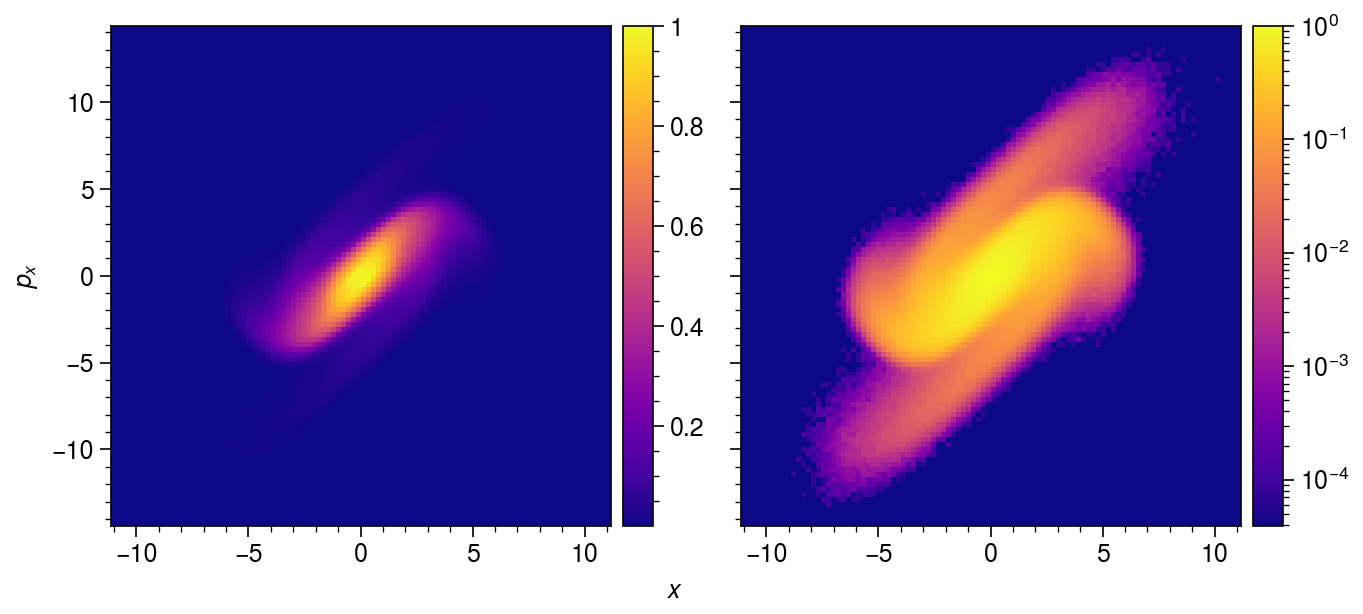

In [4]:
#| code-fold: true
grid = xr.open_dataarray("data/grid.nc")
grid_values = grid.values
grid_coords = [grid.coords["x"], grid.coords["xp"]]

fig, axs = plt.subplots(ncols=2)
for i, ax in enumerate(axs):
    plot_image(grid_values, grid_coords, ax=ax, log=i)
axs.format(xlabel=r"$x$", ylabel=r"$p_x$")

The plot on the left uses a linear color scale. The most obvious feature is a linear correlation between $x$ and $p_x$, which is caused by the linear quadrpuole focusing/defocusing in the lattice. (The beam is diverging in the horizontal plane.) You can also see some weaker nonlinear correlations near the edge of the distibution, forming the "s" shape characteristic of nonlinear dynamics. The plot on the right uses a *logarithmic* color scale. Notice that the huge nonlinear tails are completely invisible in the other plot!

Let's sample particles from the distribution, remove the linear correlation between $x$ and $p_x$, and scale to unit variance along each dimension.

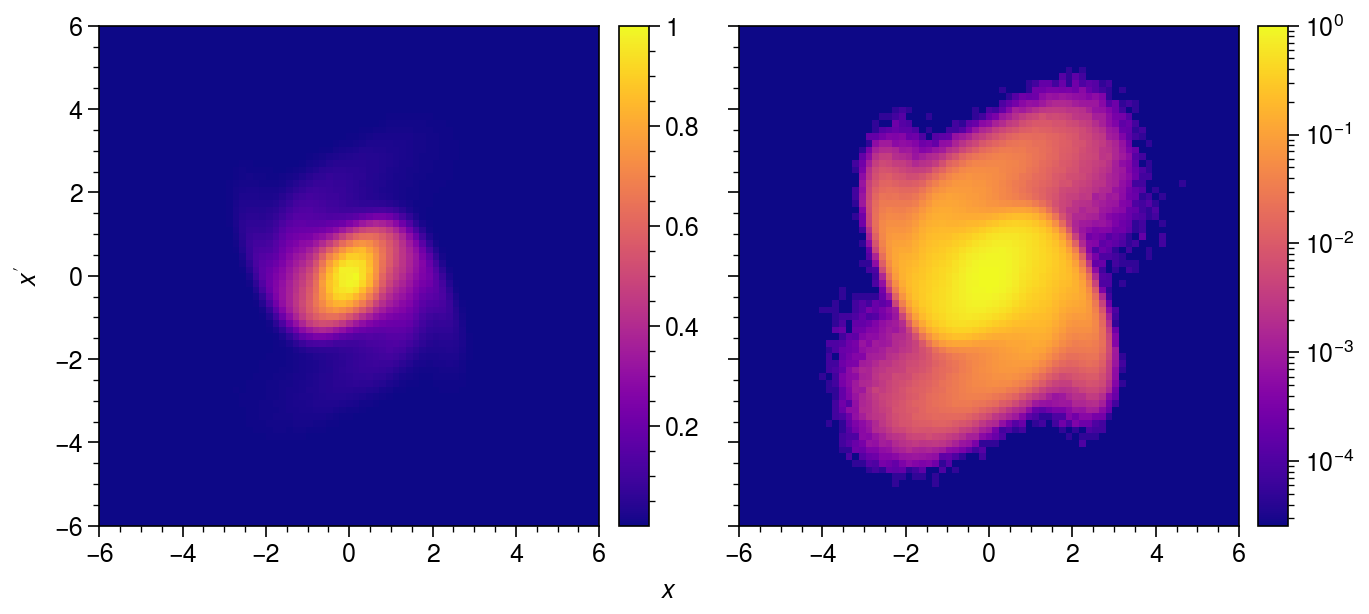

In [5]:
#| code-fold: true
# Sample particles from the discrete distribution.
x_true = sample_grid(values=grid.values, coords=grid.coords.values(), size=8_500_000, noise=1.0)

# Normalize using symplectic matrix.
cov_matrix = np.cov(x_true.T)
norm_matrix = norm_matrix_from_cov(cov_matrix)
x_true = np.matmul(x_true, norm_matrix.T)

# Plot the normalized coordinates.
xmax = 6.0
bins = 75
limits = 2 * [(-xmax, xmax)]

fig, axs = plt.subplots(ncols=2)
for i, ax in enumerate(axs):
    plot_points(x_true, bins=bins, limits=limits, ax=ax, log=i)
axs.format(xlabel=r"$x$", ylabel=r"$x'$")

## Forward model

Consider a simple forward model consisting of rotation matrices by angles uniformly spaced between $[0, \pi]$. (In typical measurement beamlines, a linear + uncoupled description of the dyanamics will be sufficient.) We'll simulate 10 measurements.

In [6]:
nmeas = 10 # number of projections
nbins = 75  # number of bins in 1D histograms

# Define rotation angles uniformly spanning [0, pi].
phase_advances = np.linspace(0.0, np.pi, nmeas, endpoint=False)

# Package rotation matrices as LinearTransform function.
transforms = []
for phase_advance in phase_advances:
    matrix = ment.utils.rotation_matrix(phase_advance)
    transform = ment.LinearTransform(matrix)
    transforms.append(transform)

# Create Histogram1D objects.
diagnostics = []
for transform in transforms:
    bin_edges = np.linspace(-xmax, xmax, nbins + 1)
    diagnostic = ment.diag.Histogram1D(axis=0, edges=bin_edges)
    diagnostics.append([diagnostic])

# Generate training data from ground truth distribution. 
projections = ment.simulate(x_true, transforms, diagnostics)

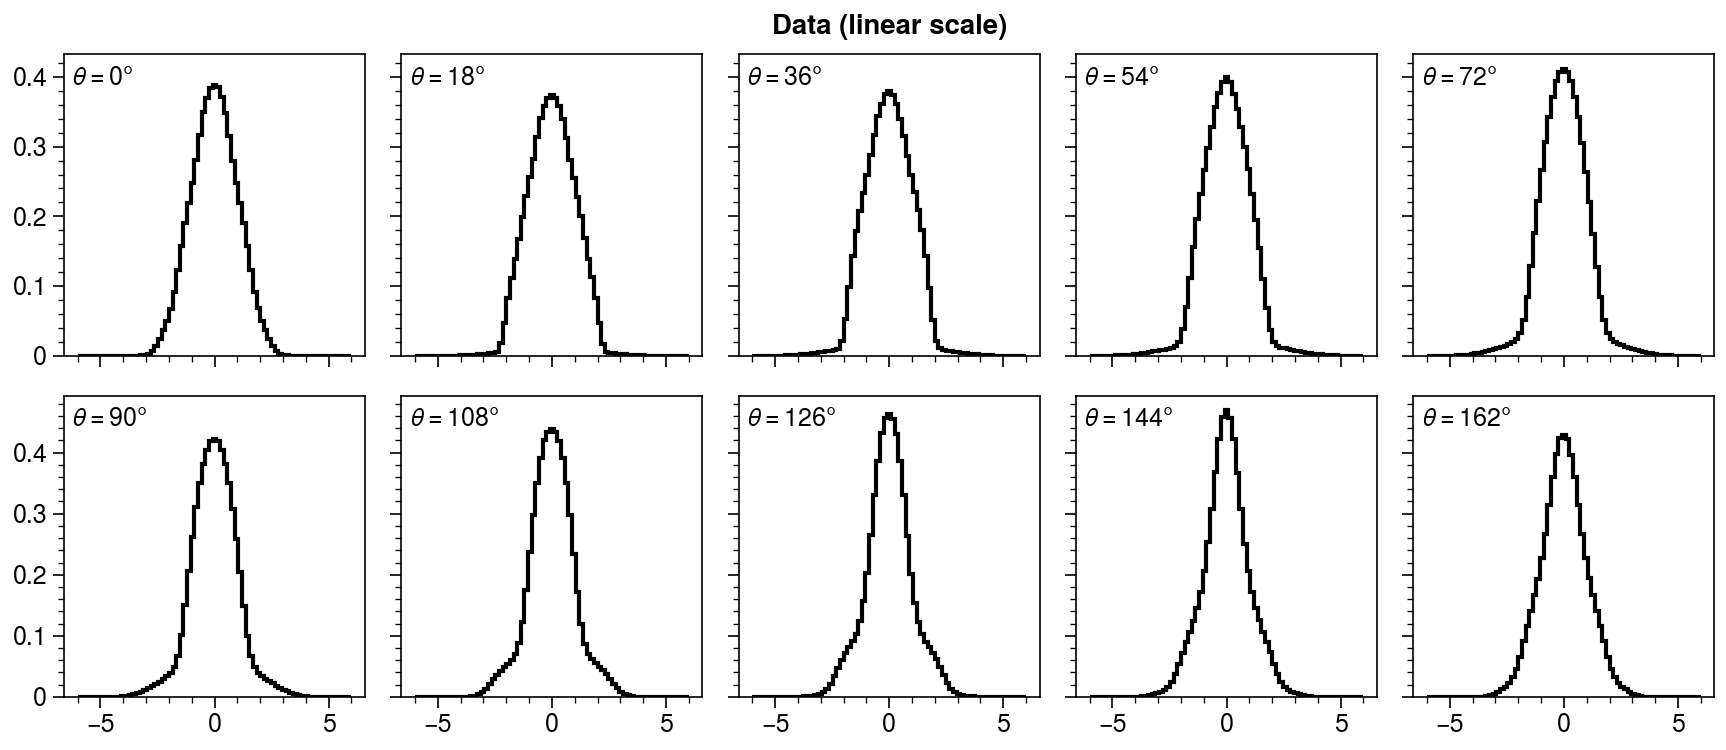

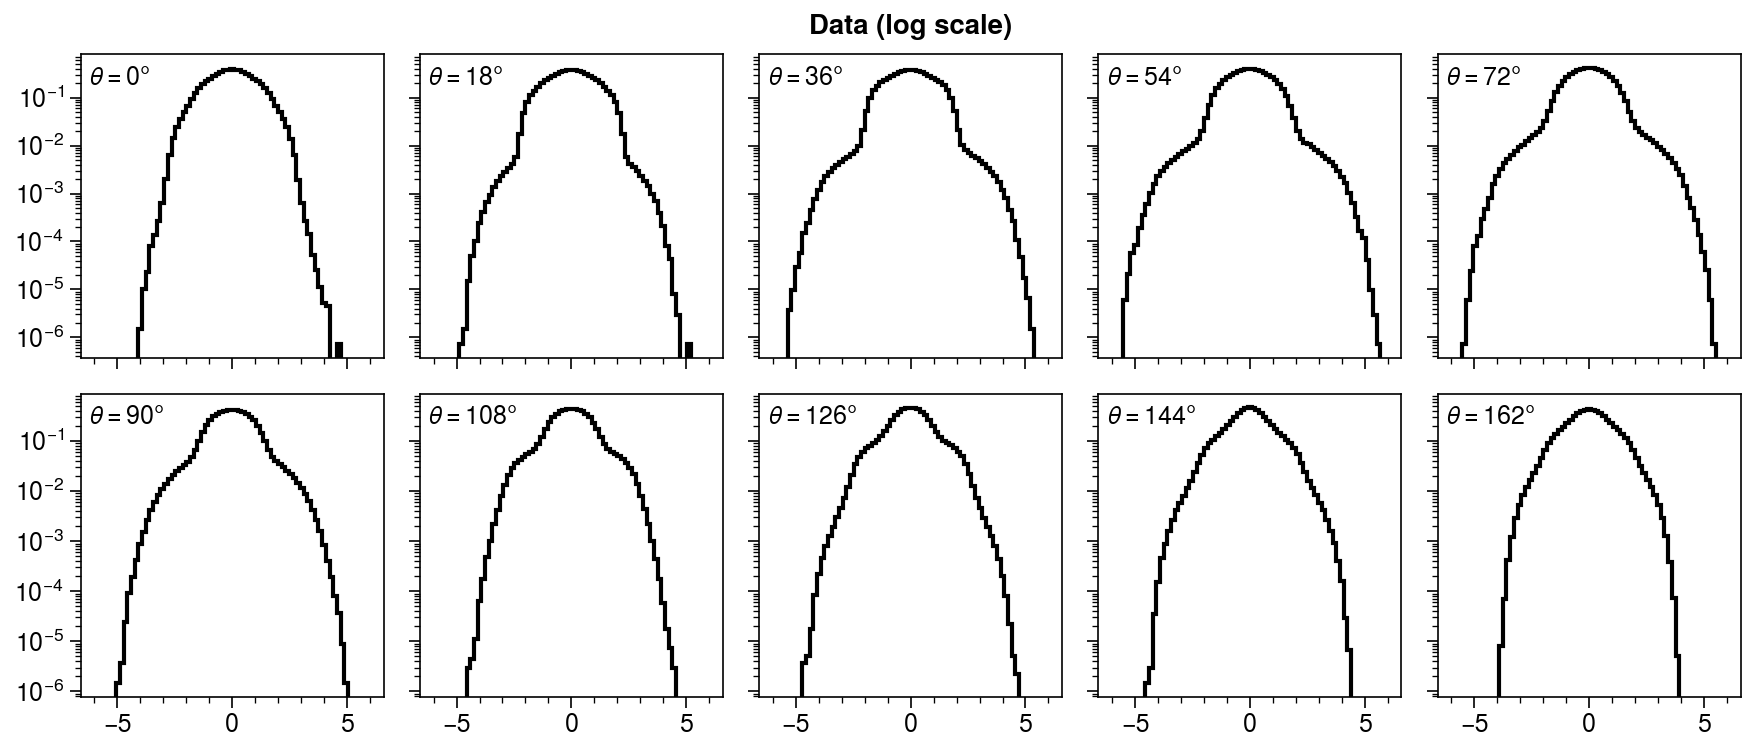

In [7]:
#| code-fold: true
for log in [False, True]:
    fig, axs = plt.subplots(ncols=5, nrows=2, figheight=3.75)
    for ax, projection, phase_advance in zip(axs[:10], ment.unravel(projections), phase_advances):
        ax.stairs(projection.values, projection.edges, color="black", lw=1.5)
        ax.annotate(r"$\theta = {:0.0f}\degree$".format(np.degrees(phase_advance)), xy=(0.025, 0.9), xycoords="axes fraction")
    if log:
        axs.format(yscale="log", yformatter="log")
    if log:
        axs.format(suptitle="Data (log scale)")
    else:
        axs.format(suptitle="Data (linear scale)")

## Reconstruction model

I'll use the MENT algorithm linked above. It requires a list of transformation functions (`transforms`), which map the distribution from the reconstruction point to each measurement, as well as a list of measured projections (`projections`). It also requires a prior distribution, which I'll take to be ~uniform over the phase space. I'll use numerical integration to simulate the projections, which is quite fast in 2D.

In [8]:
# Defina a wide Gaussian prior (basically uniform).
ndim = 2
prior = ment.GaussianPrior(ndim=ndim, scale=5.0)

# Create sampler to sample particles from the distribution (for plotting).
sampler = ment.GridSampler(grid_limits=limits, grid_shape=(200, 200))

# Define integration grid limits and resolution for each measurement. In this case 
# the grid is one-dimenisonal.
integration_size = 100
integration_limits = [[limits,] for transform in transforms]

# Create MENT reconstruction model.
model = ment.MENT(
    ndim=2,
    projections=projections,
    transforms=transforms,
    prior=prior,
    integration_size=integration_size,
    integration_limits=integration_limits,
    sampler=sampler,
    mode="integrate",
    interpolation_kws=dict(method="linear"),
    verbose=False,
)

## Training loop

We train MENT by Gauss-Seidel iterations. This is a relaxation method that gradually pushes the distribution from the prior to the posterior, i.e. from the unconstrained to constrained maximum-entropy distribution.

In [9]:
#| code-fold: true
#| code-summary: "Plotting functions"
def plot_model_proj(x_pred: np.ndarray) -> tuple:
    # Simulate data.
    projections_pred = ment.simulate(x_pred, model.transforms, model.diagnostics)
    projections_pred = ment.unravel(projections_pred)
    projections_meas = ment.unravel(model.projections)

    fig, axs = plt.subplots(ncols=5, nrows=4, figheight=7.5)
    index = 0
    for j in range(nmeas):
        projection_pred = projections_pred[j]
        projection_meas = projections_meas[j]            
        scale = projection_meas.values.max()
        for i in range(2):
            index = j + i * nmeas
            ax = axs[index]
            for k, projection in enumerate([projection_pred, projection_meas]):
                ax.plot(
                    projection.coords, 
                    projection.values / scale,
                    color="black",
                    alpha=[0.25, 1.0][k],
                    lw=[1.5, 0.0][k],
                    ms=[0.0, 3.0][k],
                    marker=[None, "."][k],
                )
            ax.format(ymax=1.25)
            if i:
                ax.format(yscale="log", ymax=5.0, ymin=1.00e-06, yformatter="log")   
            ax.annotate(f"{j:02.0f}", xy=(0.02, 0.92), xycoords="axes fraction")
    axs.format(xlabel=r"$x$")
    return fig, axs


def plot_model_dist(x_pred: np.ndarray) -> tuple:
    fig, axs = plt.subplots(ncols=2, nrows=2)
    for j, x in enumerate([x_pred, x_true]):
        for i in range(2):
            plot_points(x, bins=85, limits=limits, ax=axs[i, j], log=i)
    axs.format(
        toplabels=["MENT", "TRUE"], 
        toplabels_kw=dict(weight="normal", size="medium"), 
        xlabel=r"$x$",
        ylabel=r"$p_x$",
    )
    return fig, axs

epoch = 0


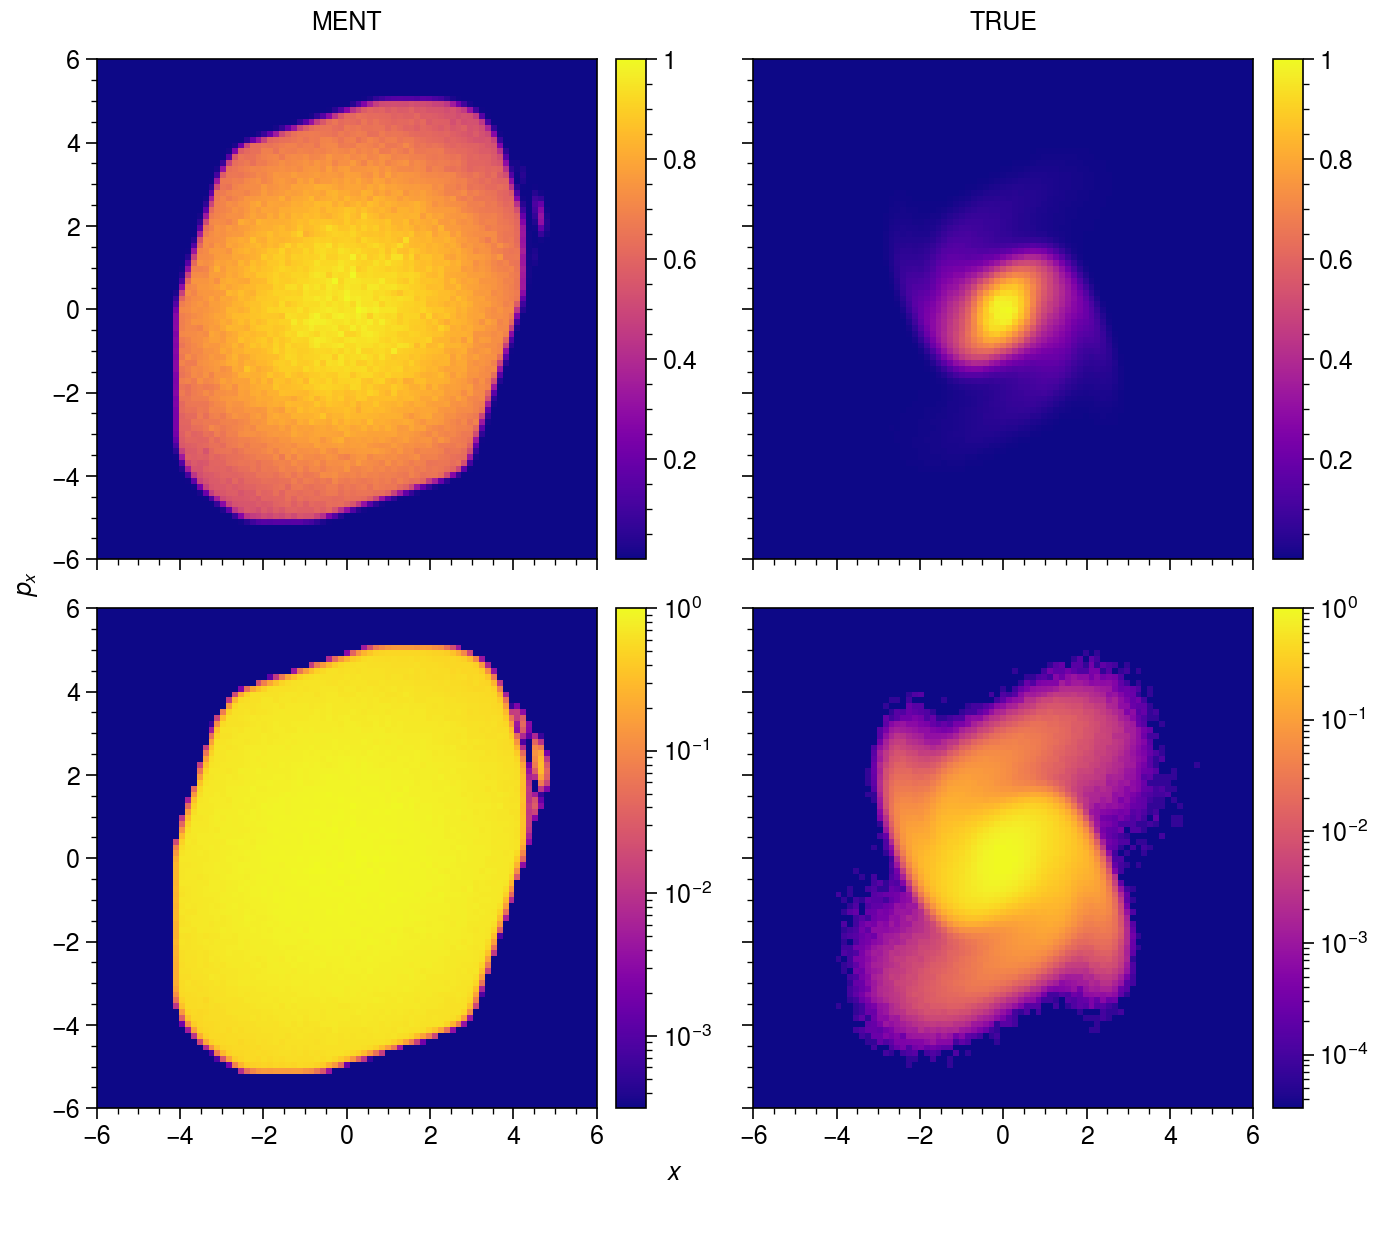

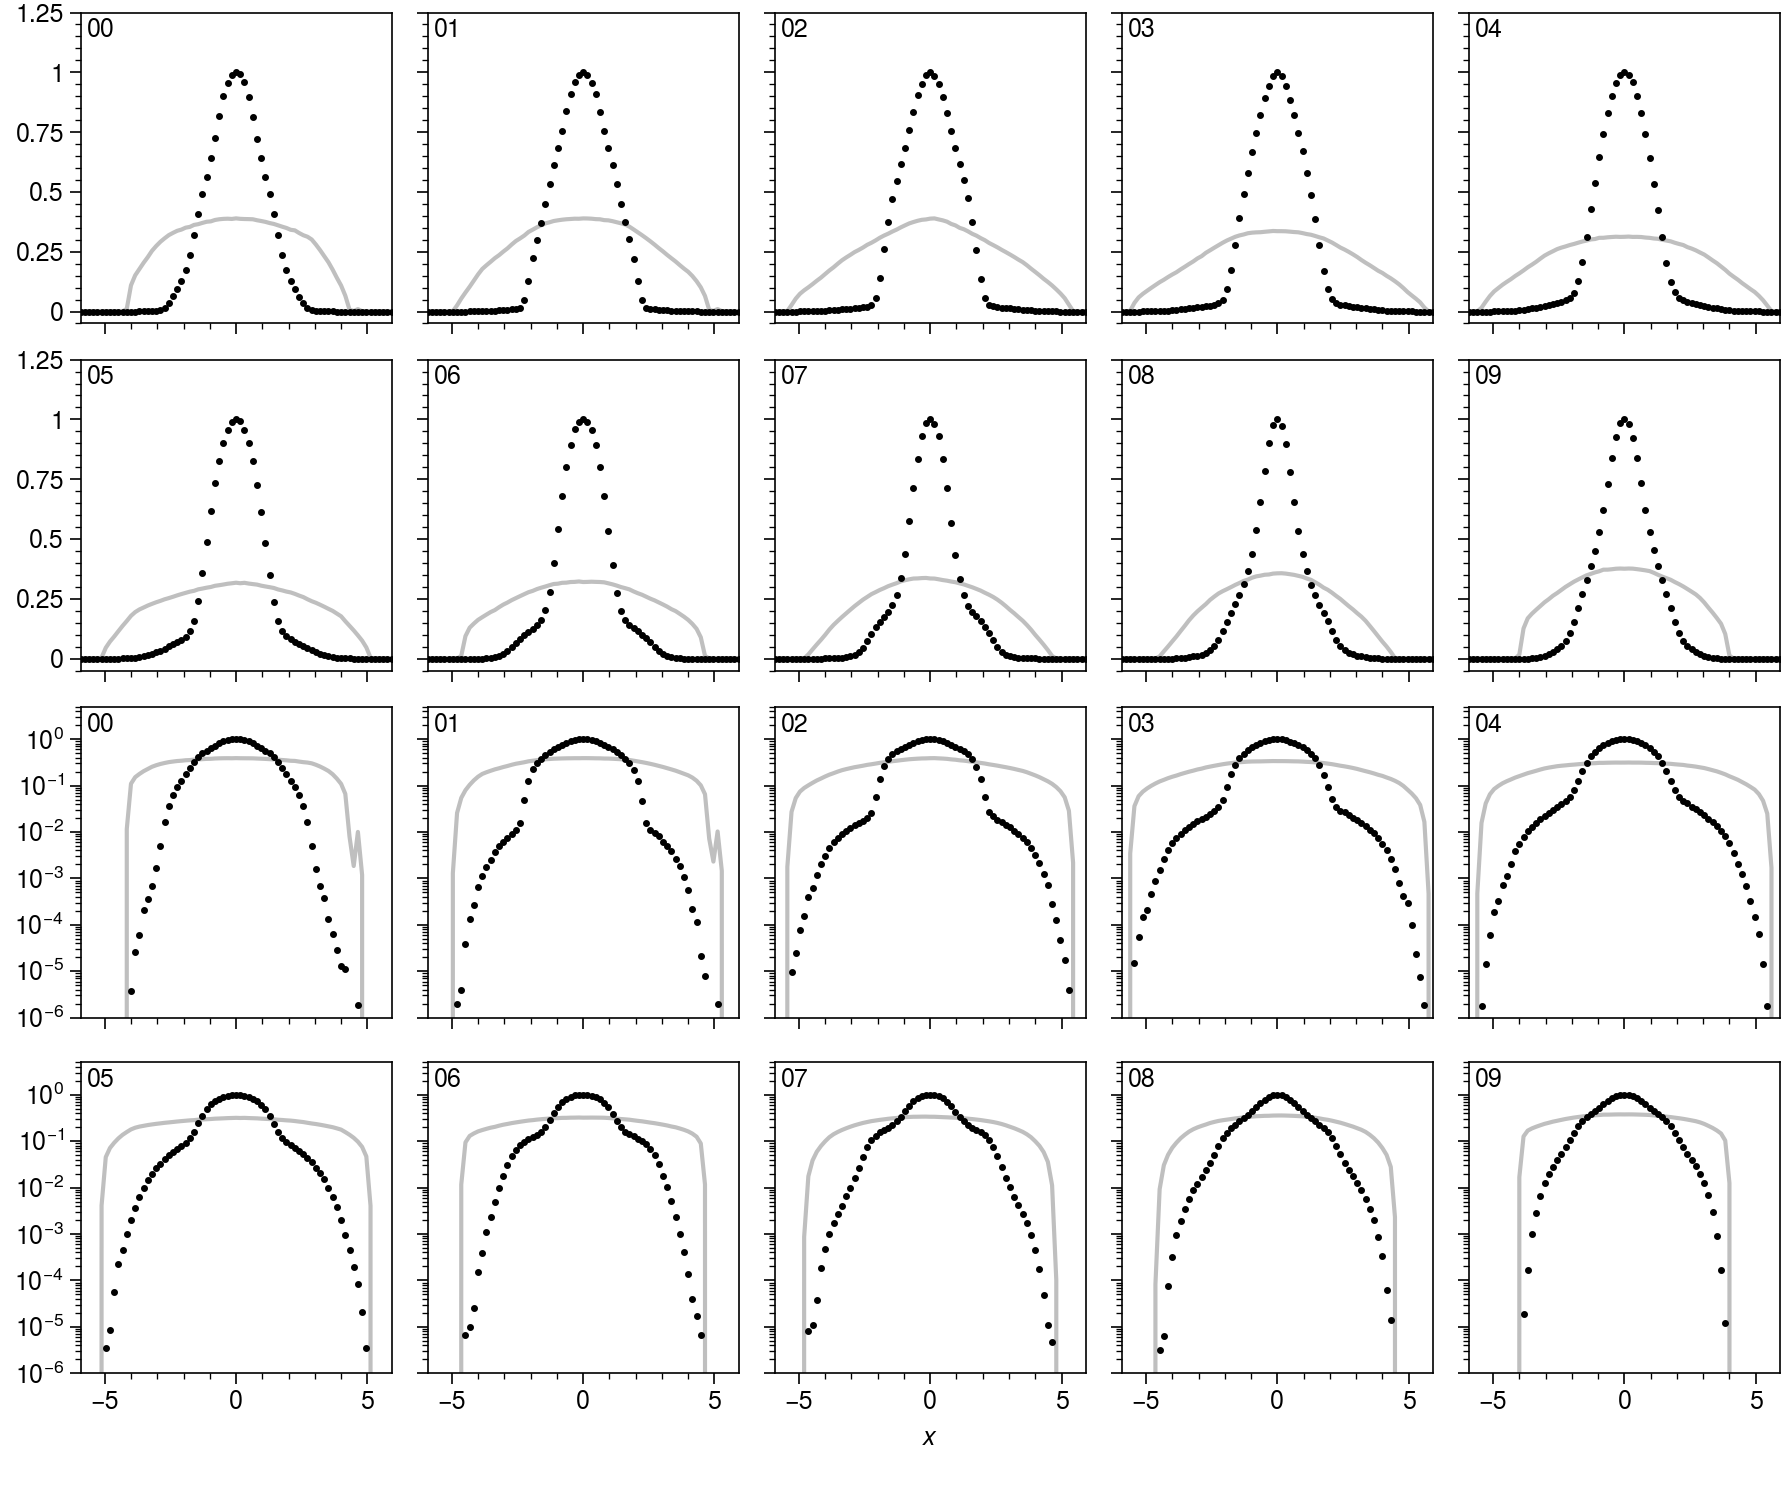

epoch = 1


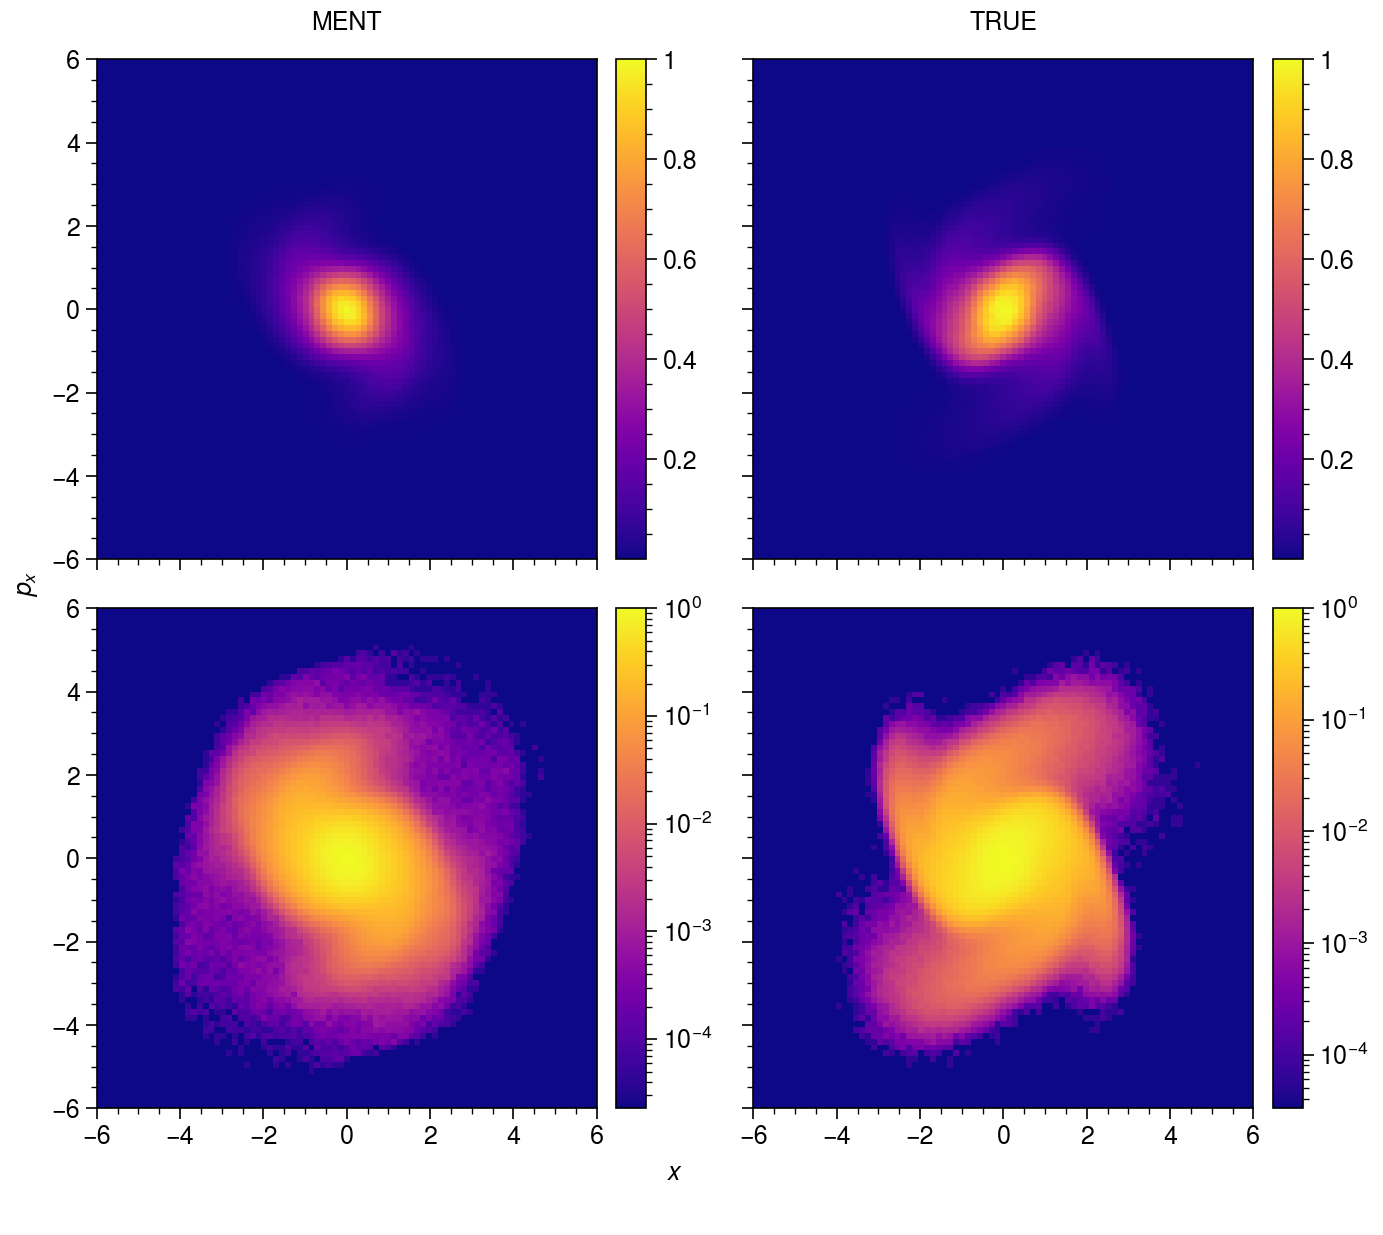

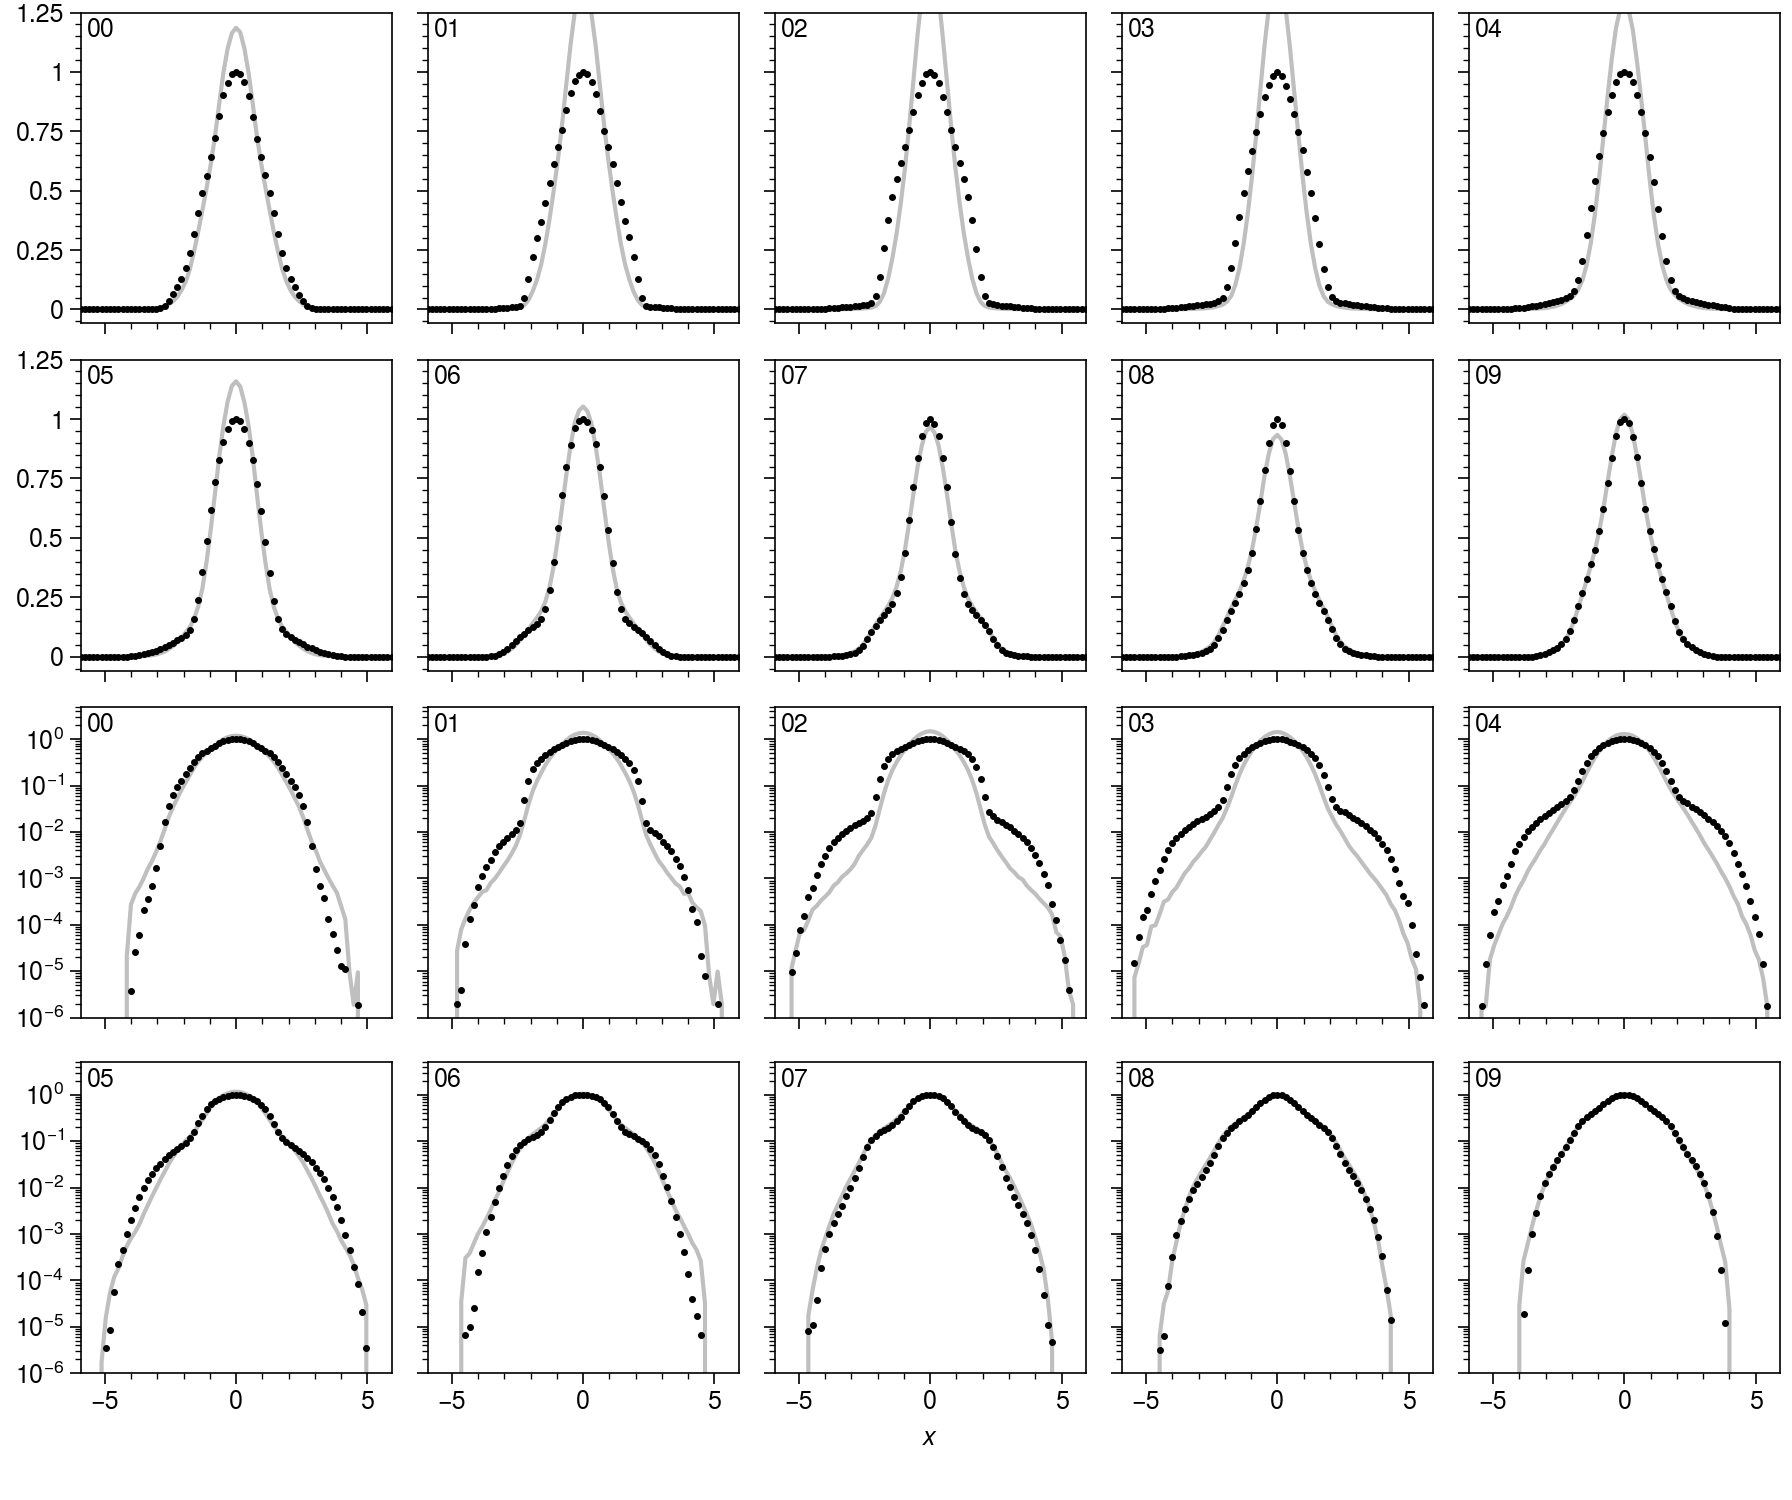

epoch = 2


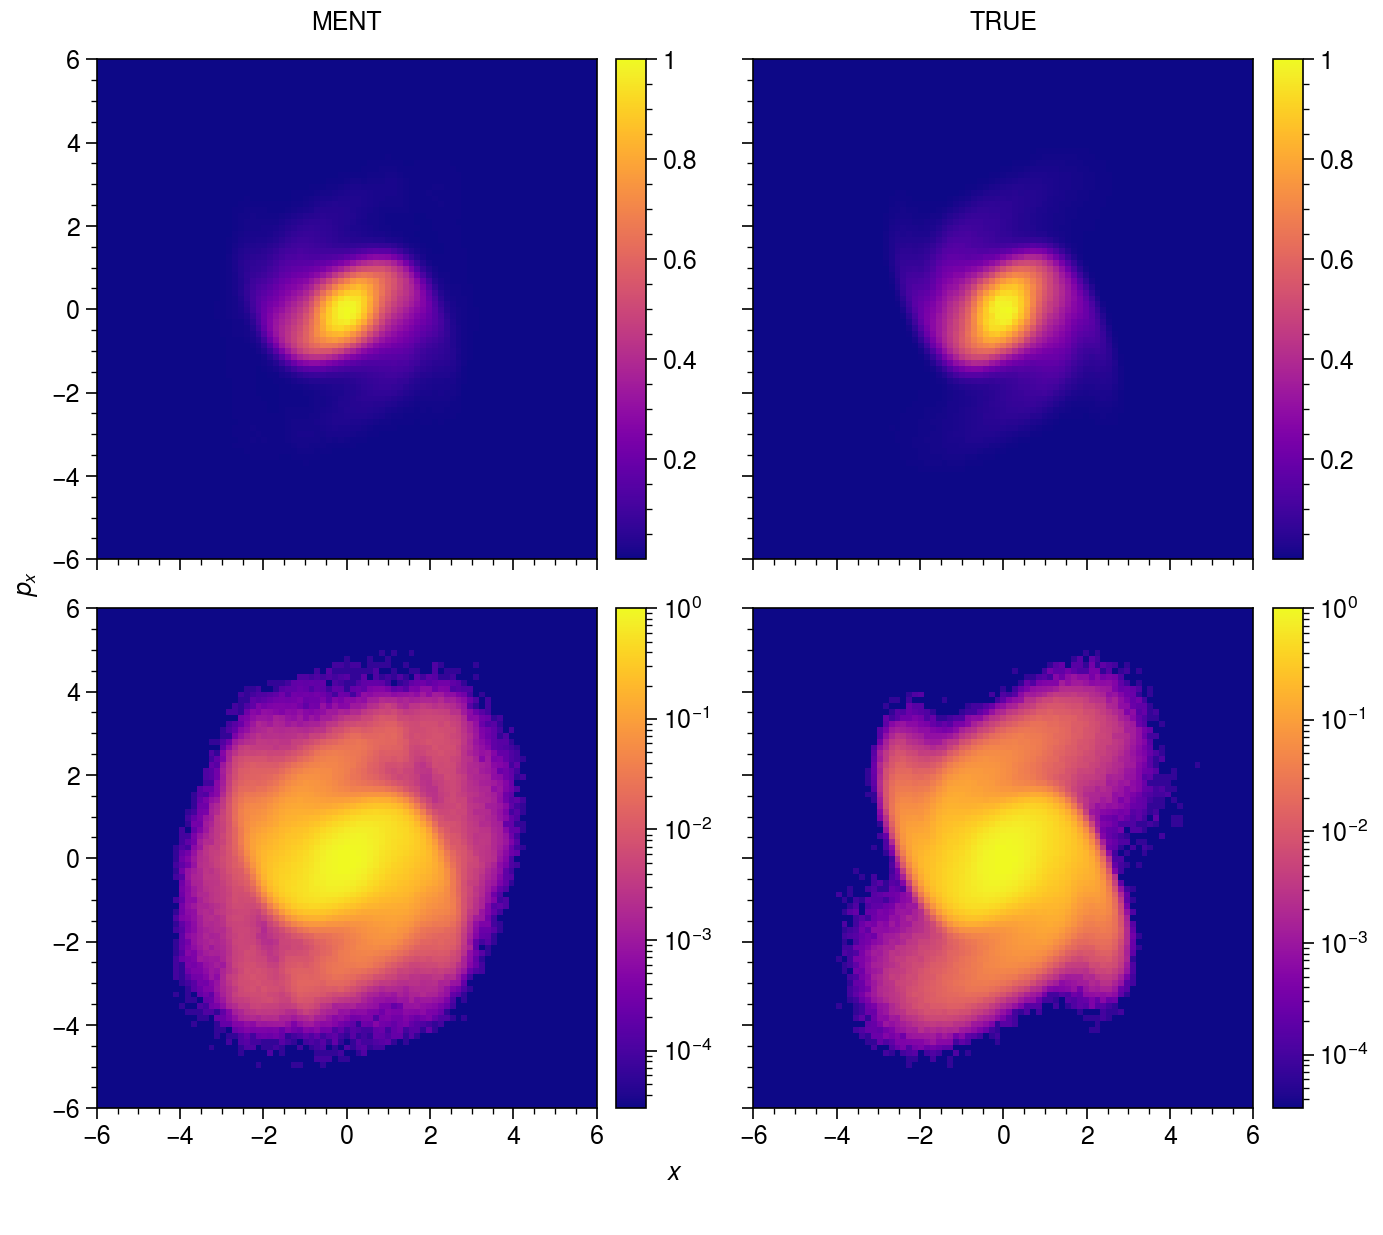

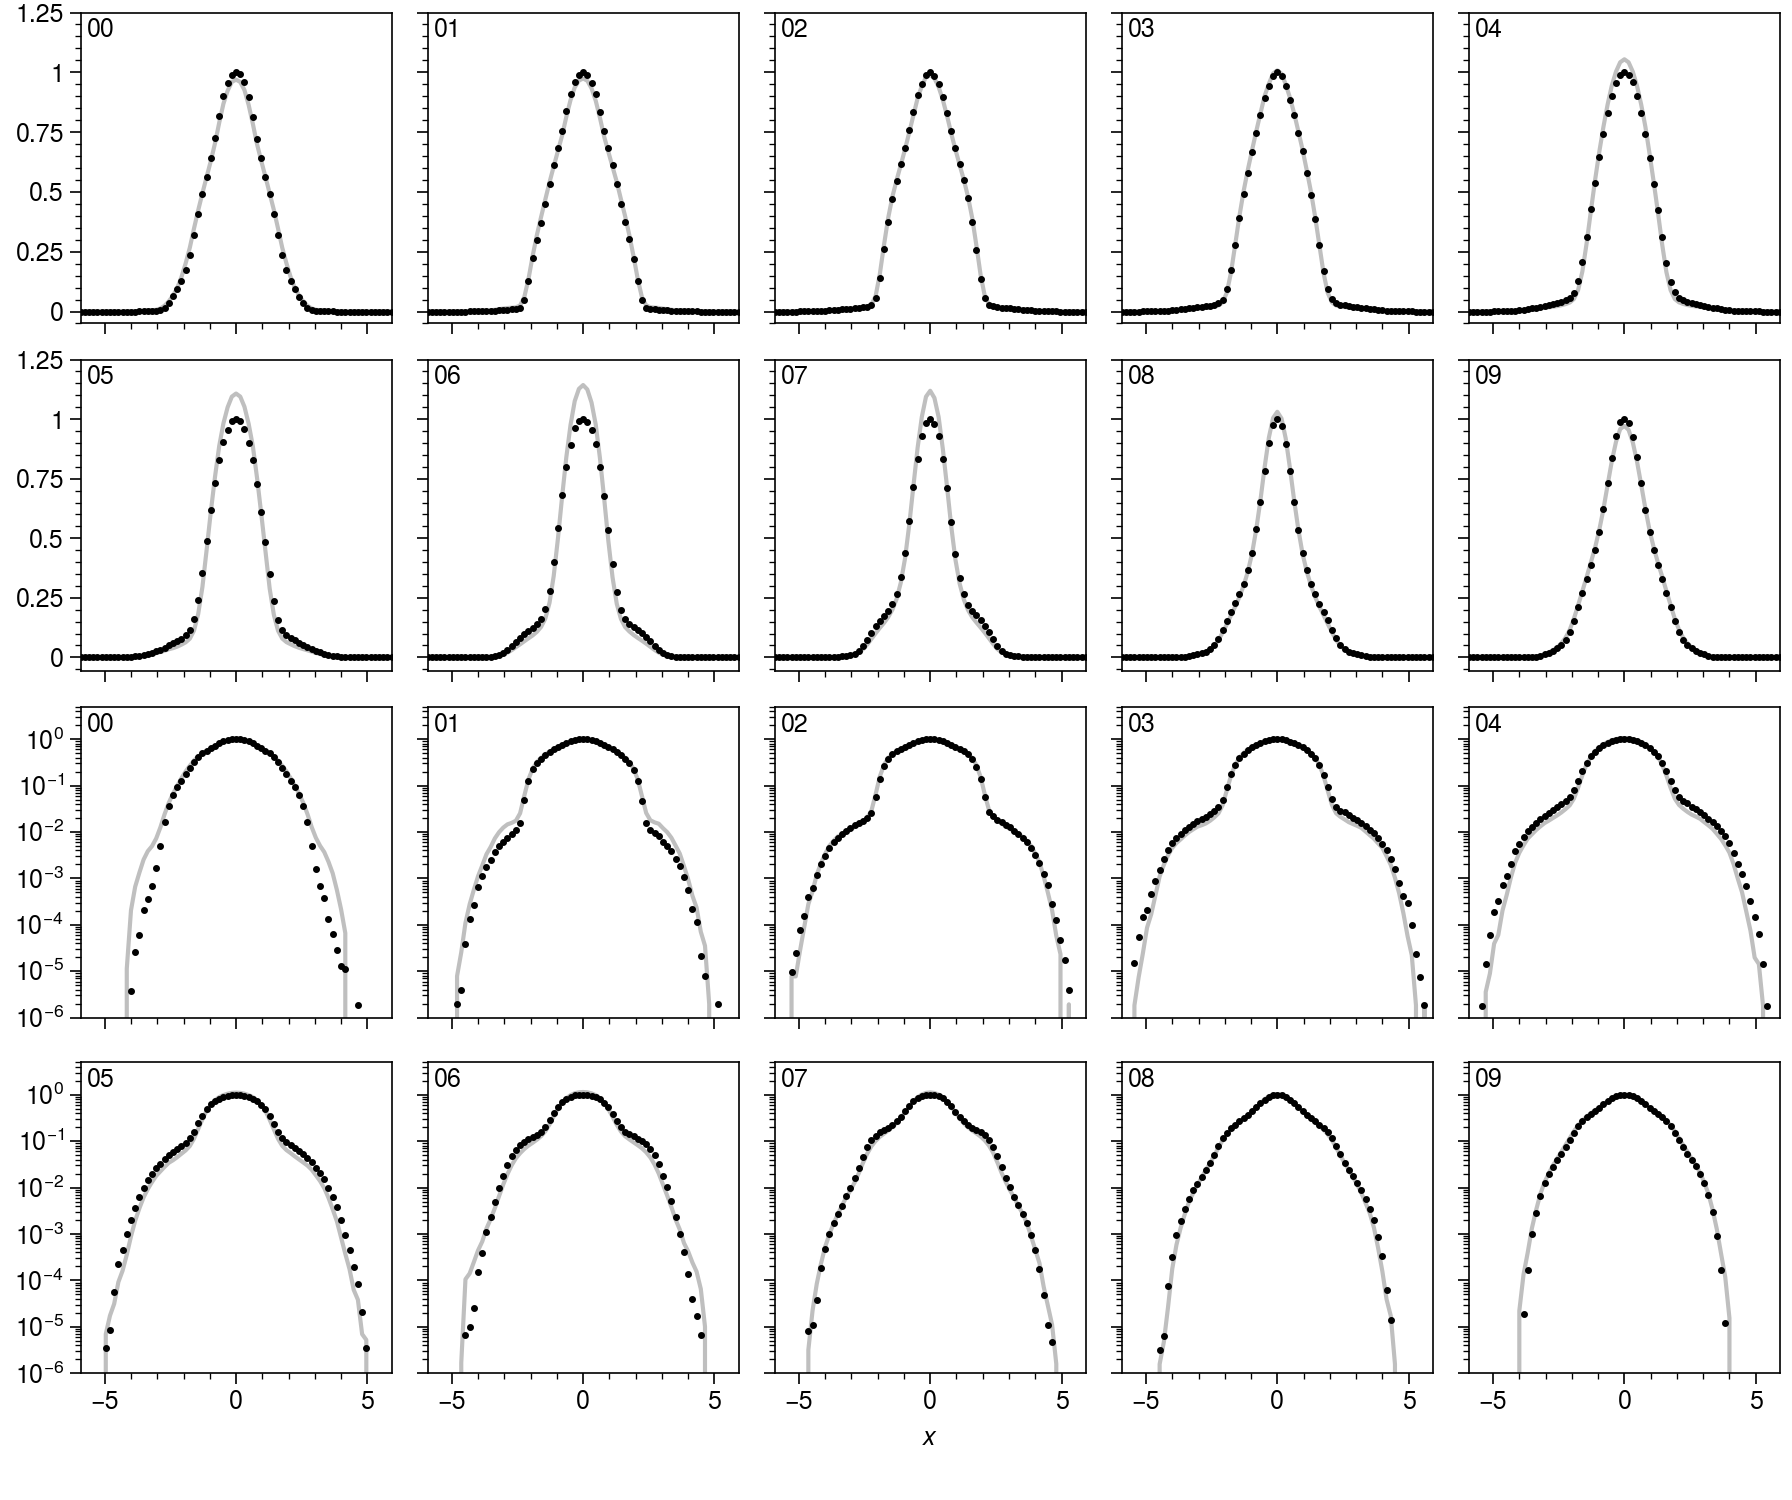

epoch = 3


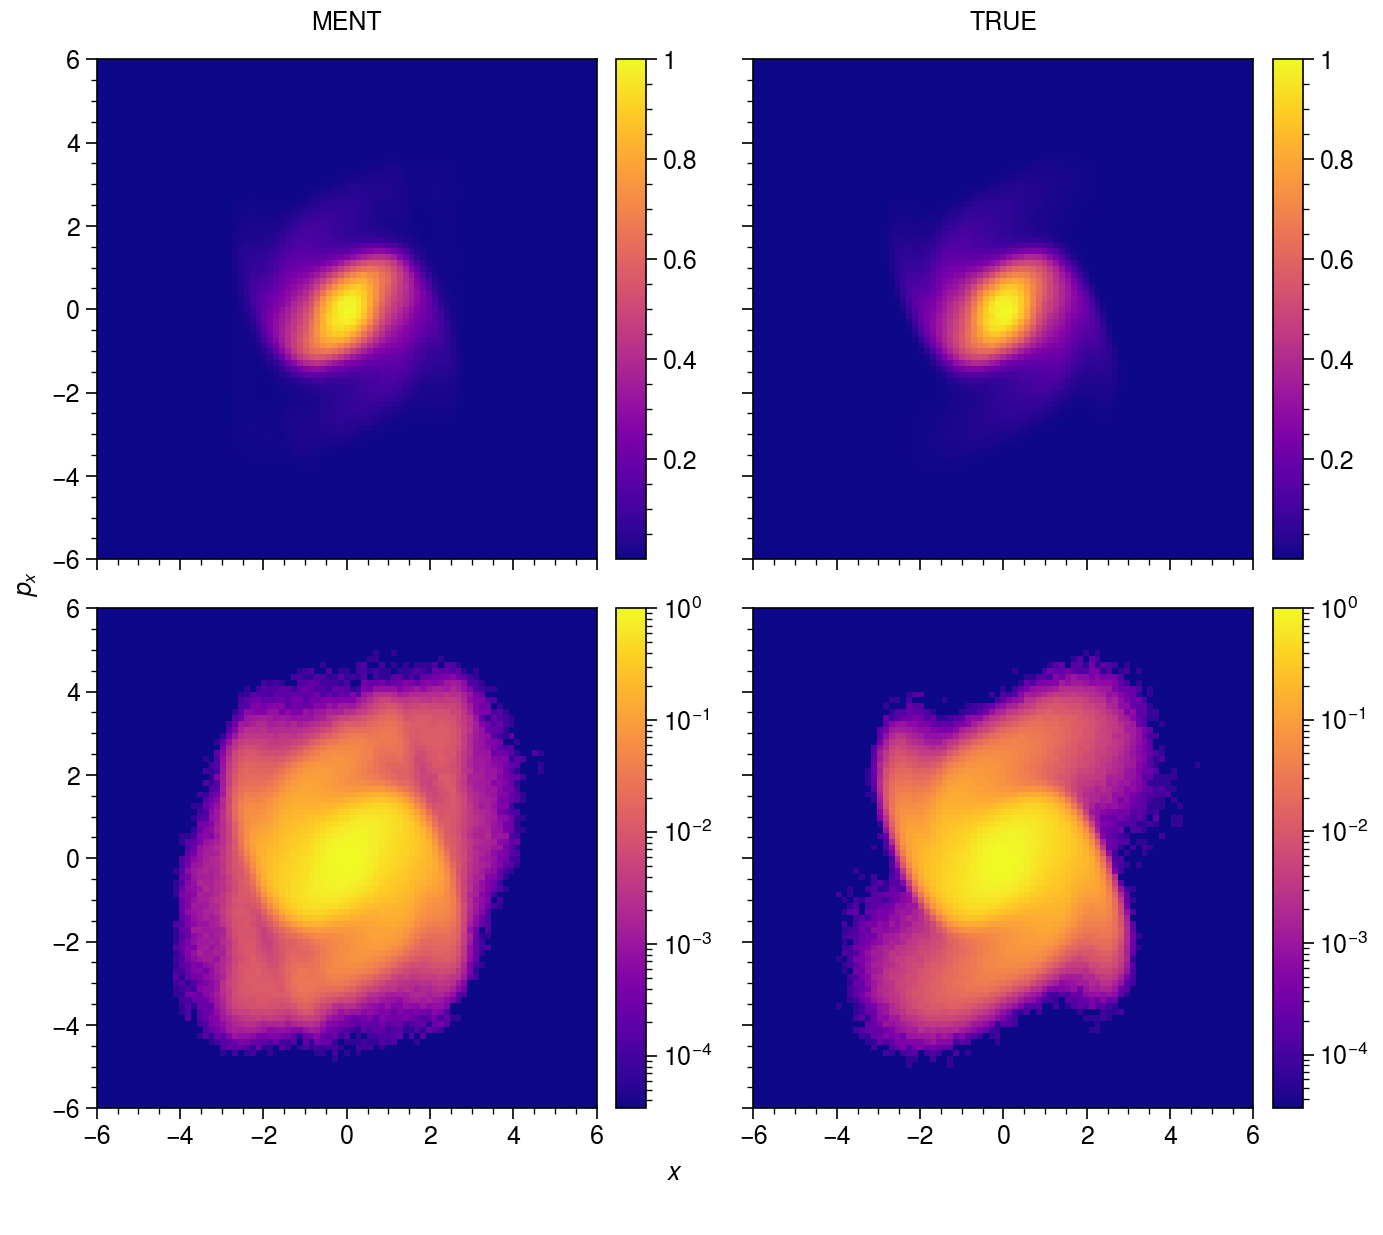

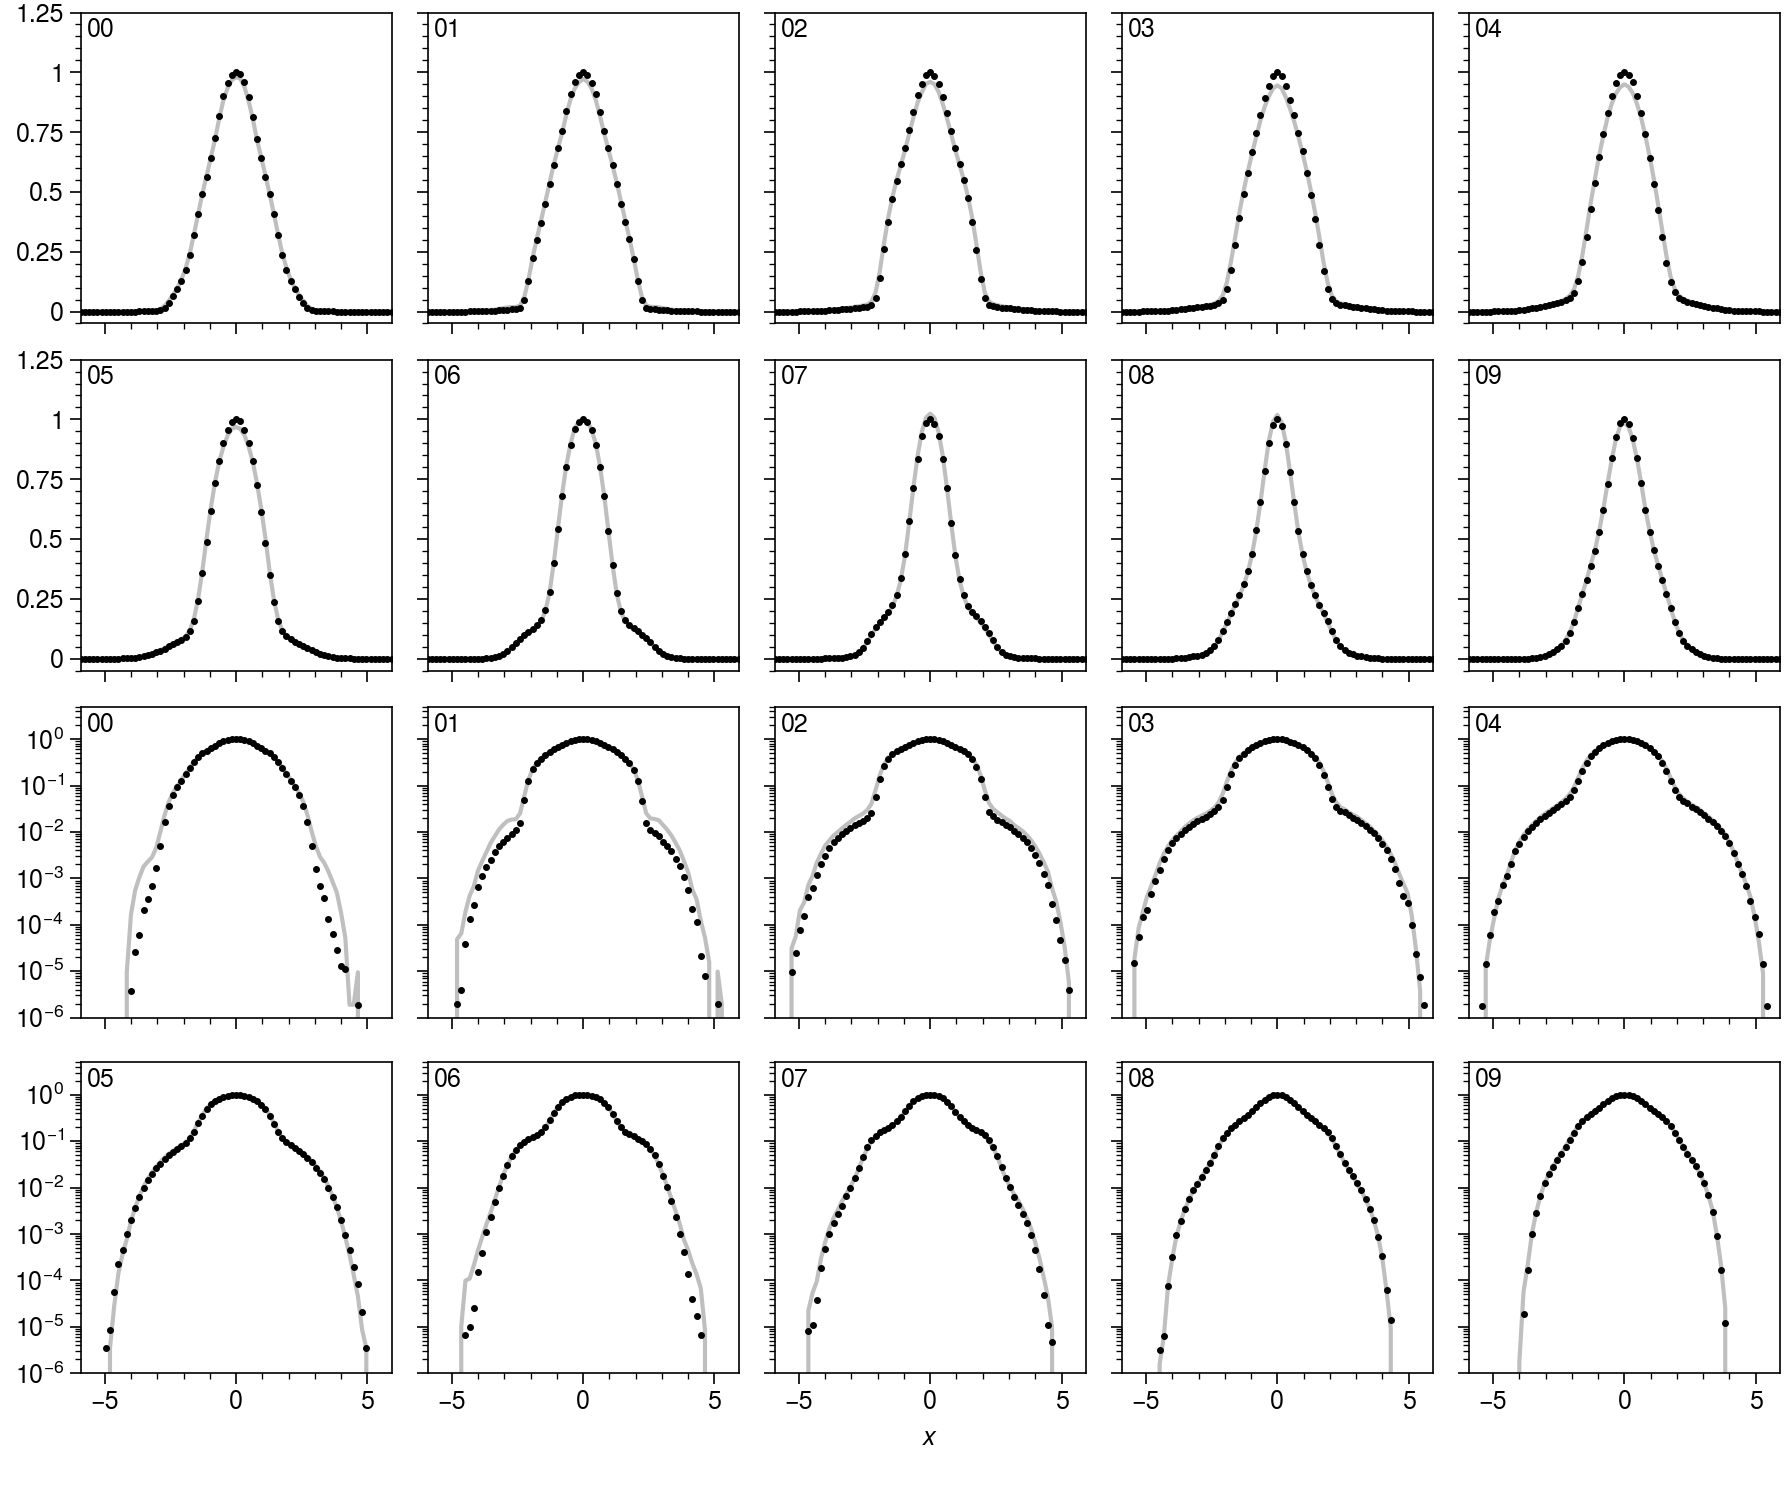

epoch = 4


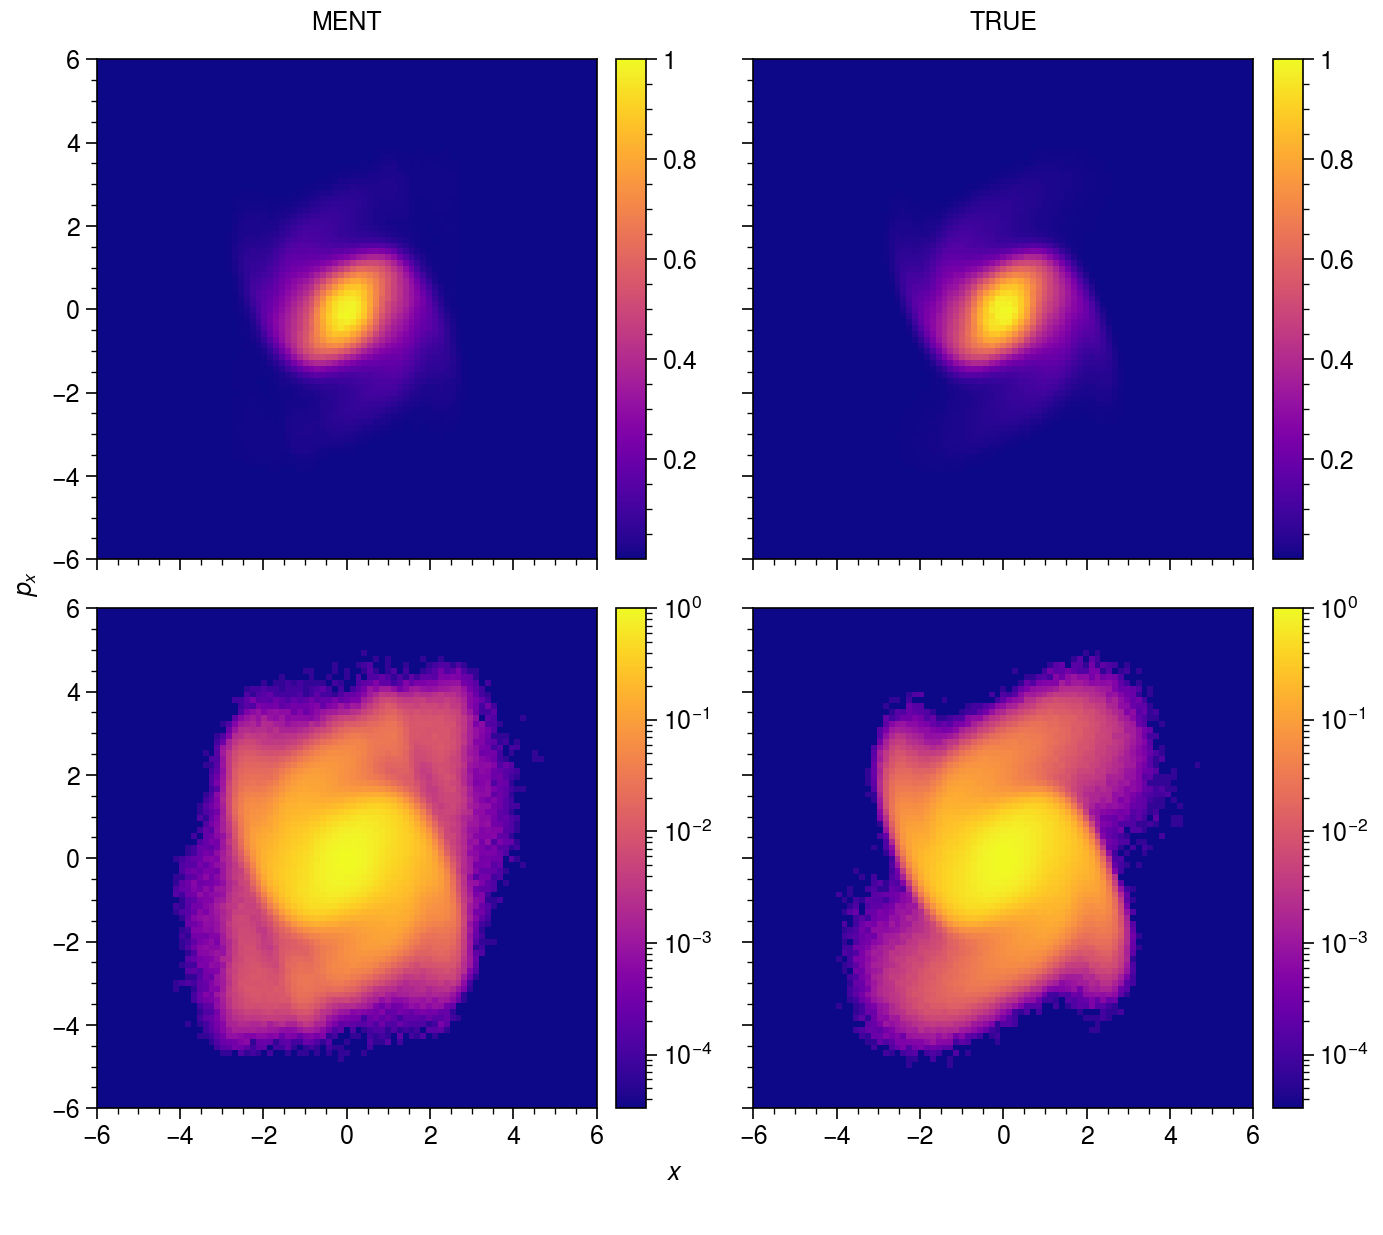

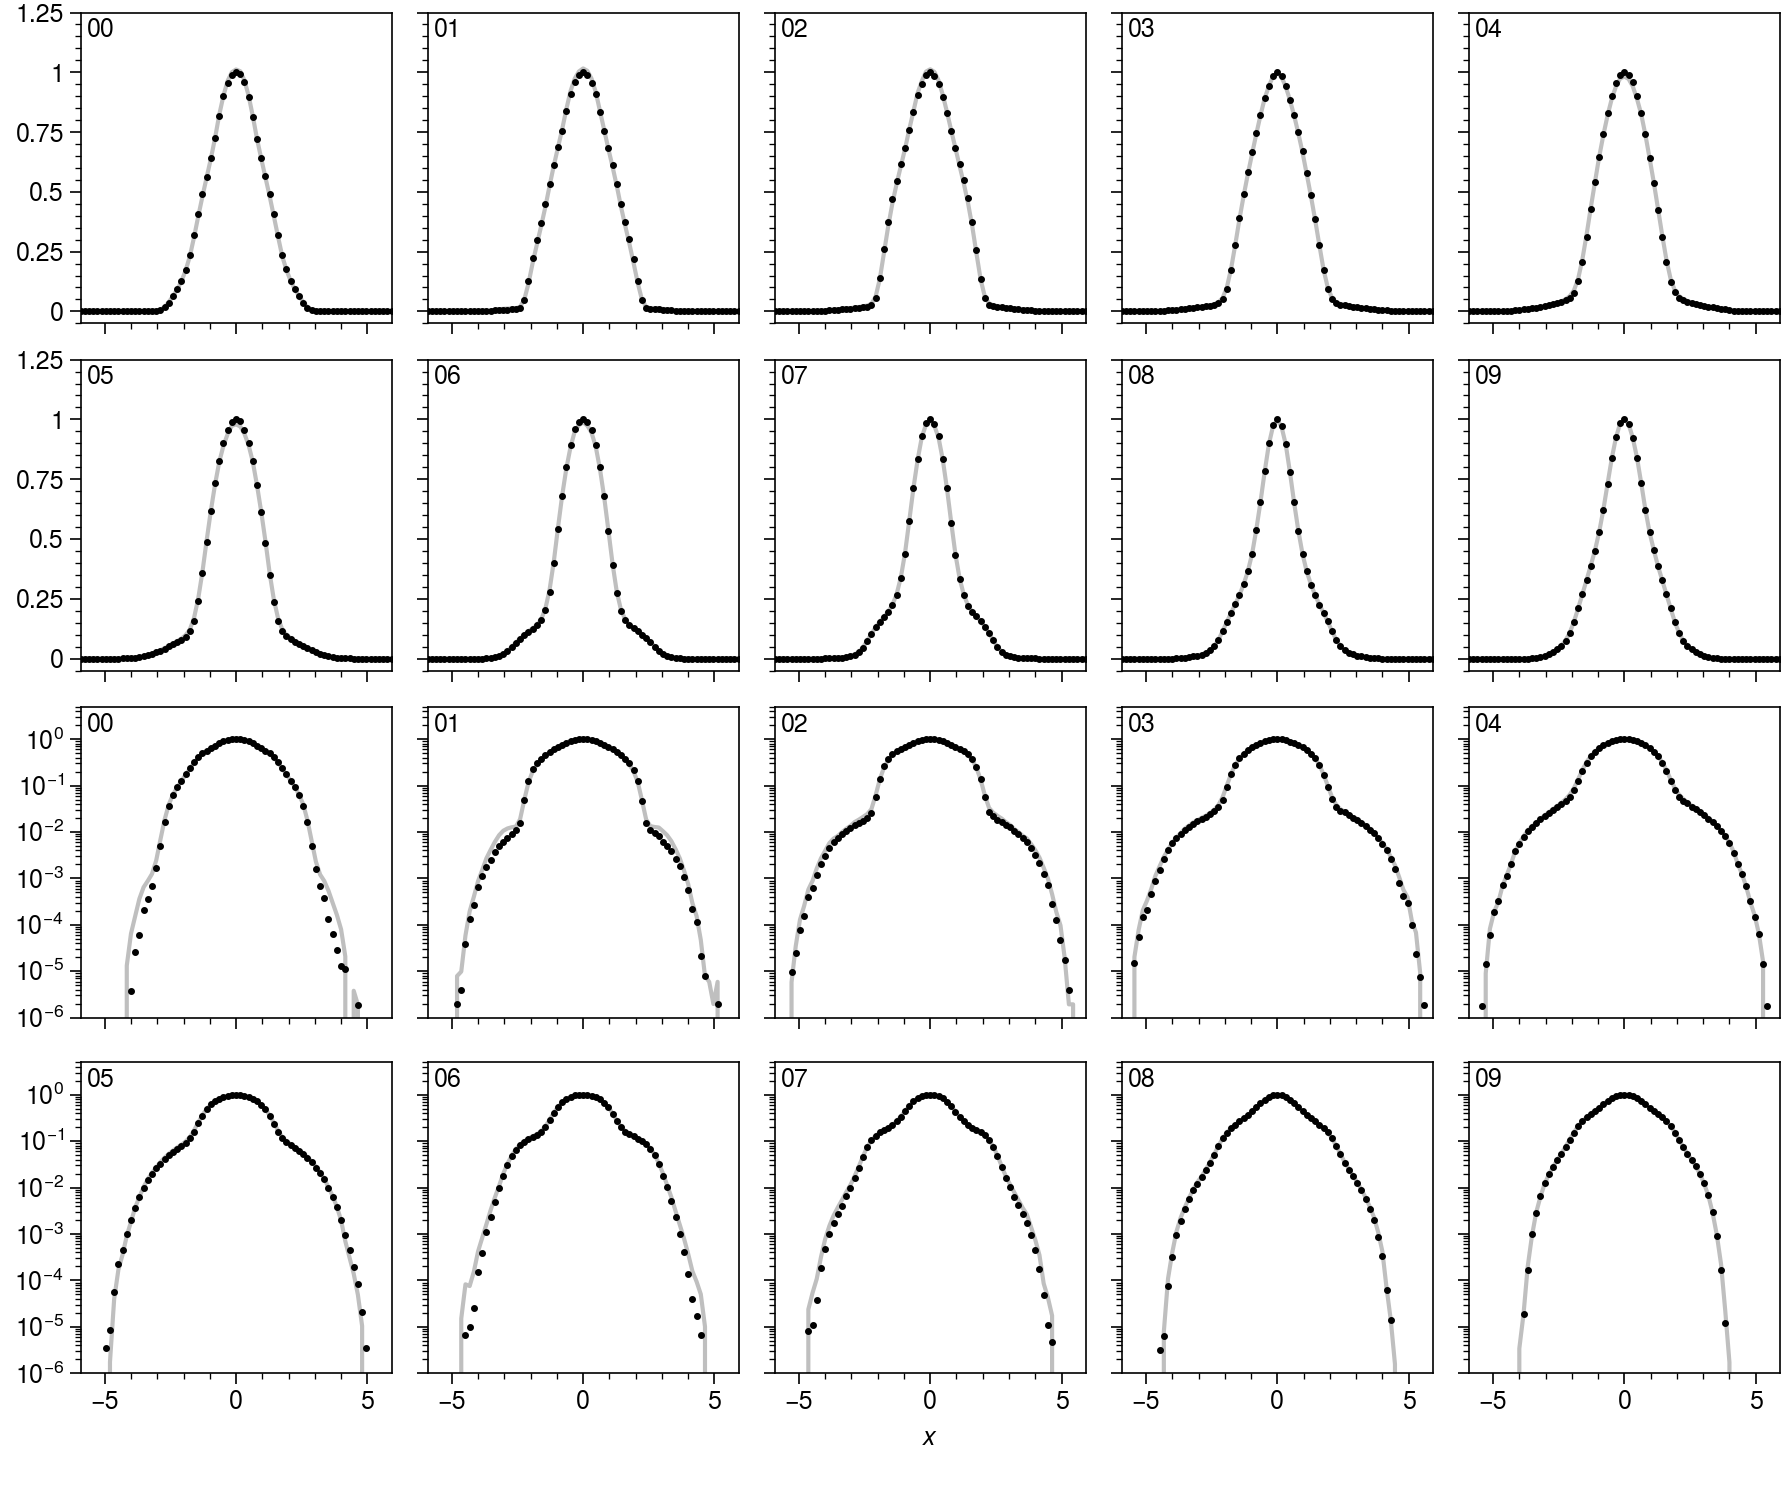

epoch = 5


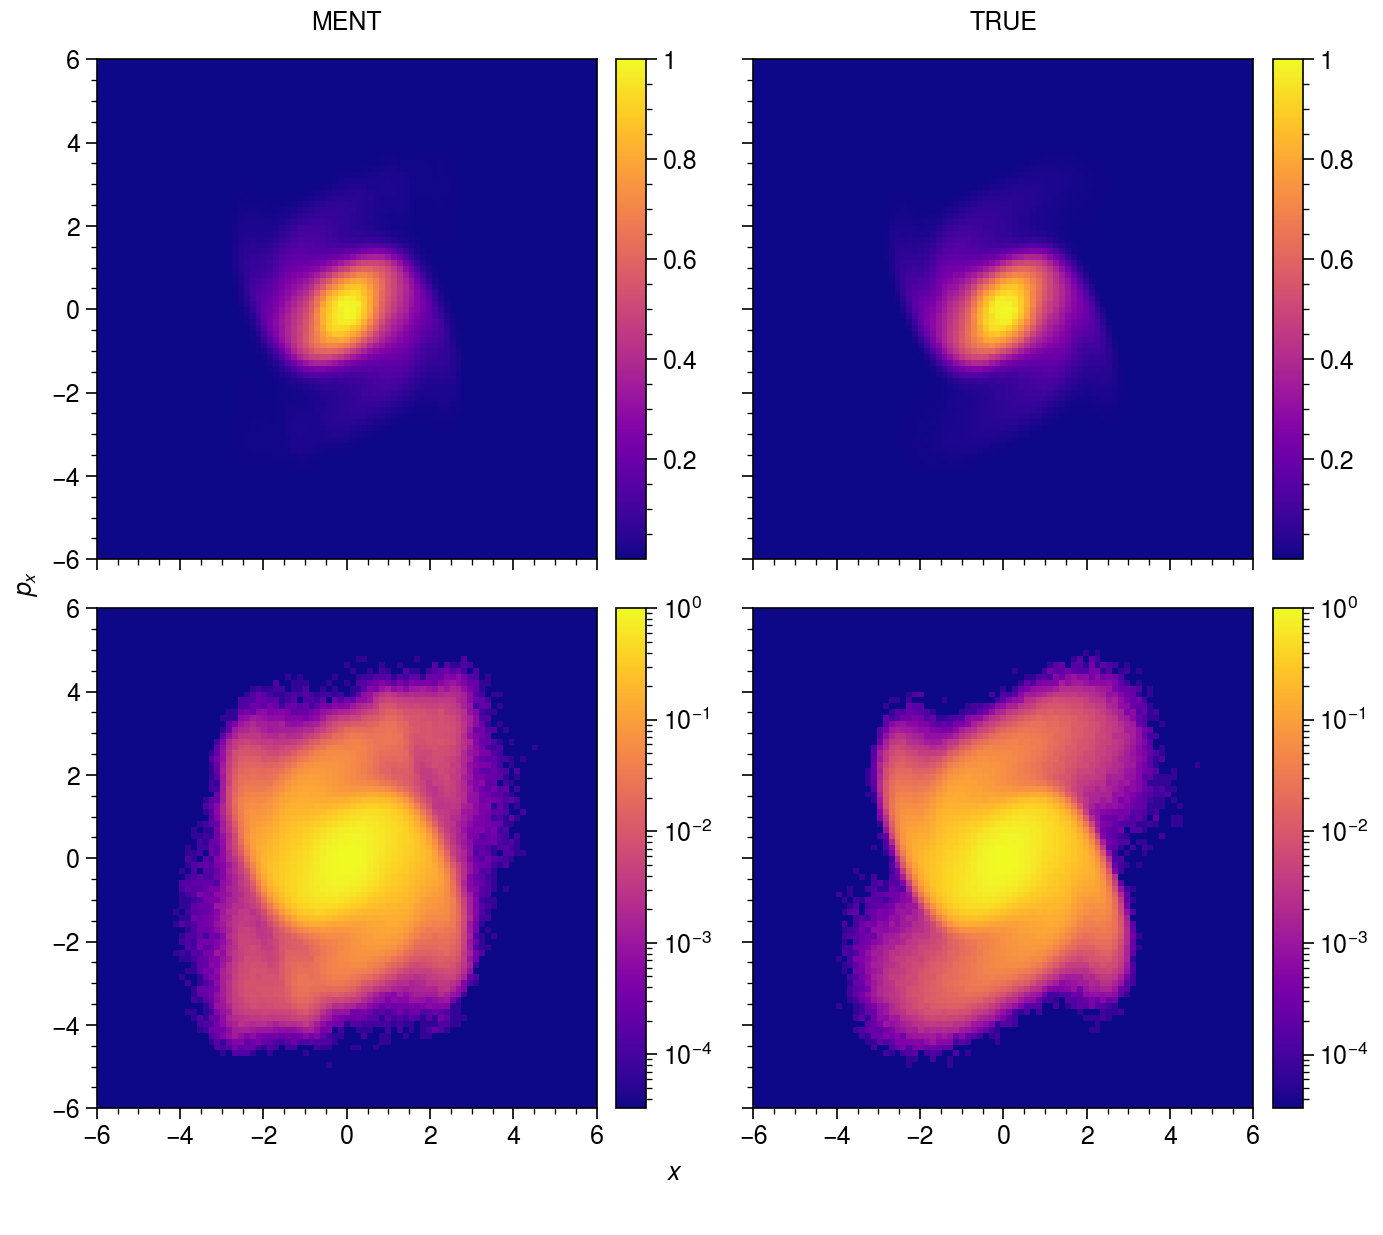

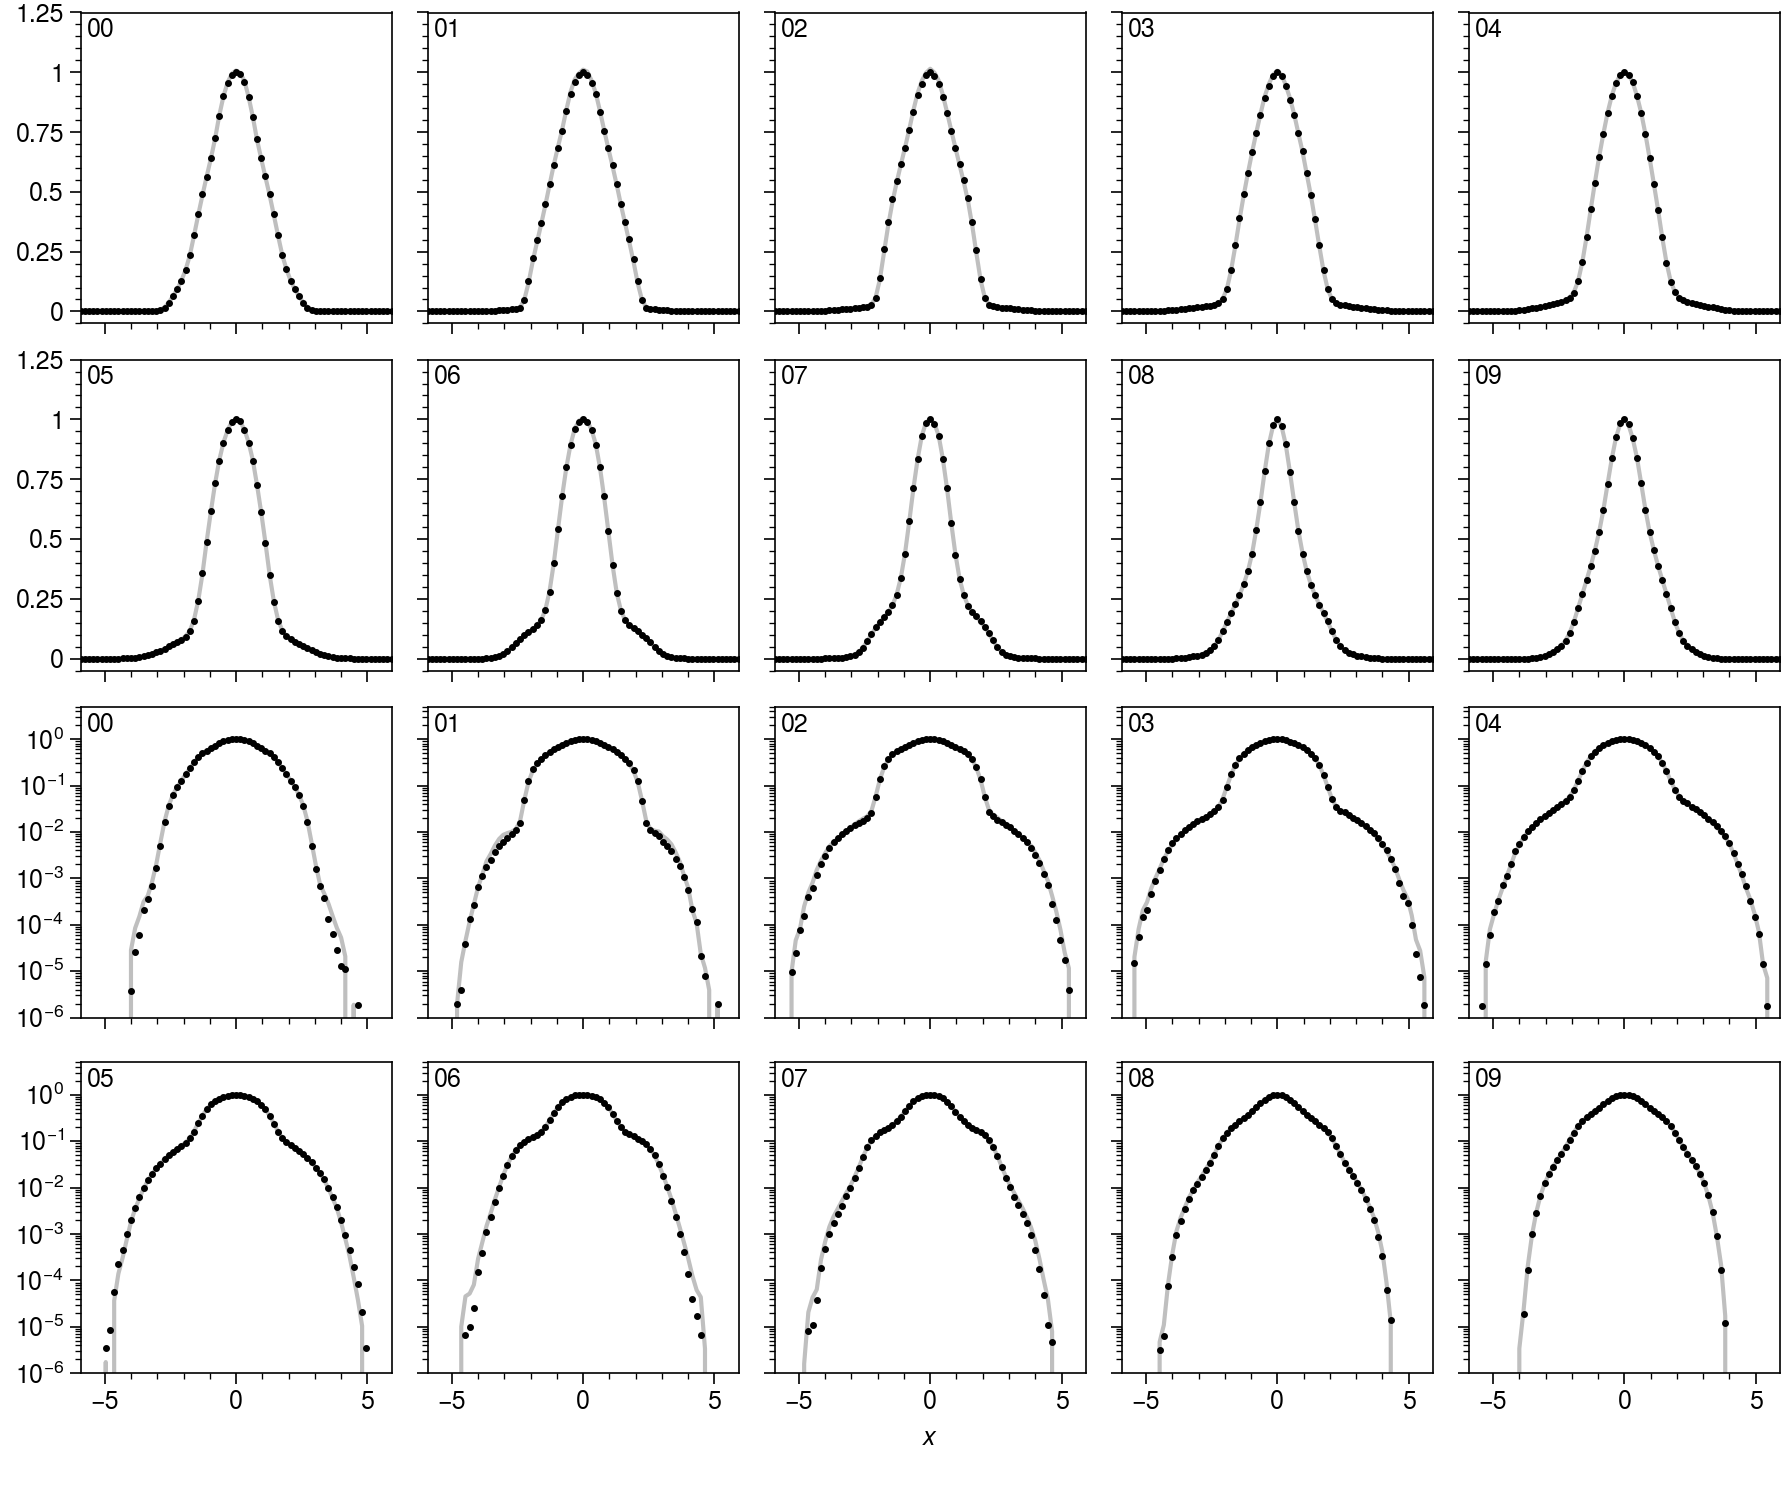

epoch = 6


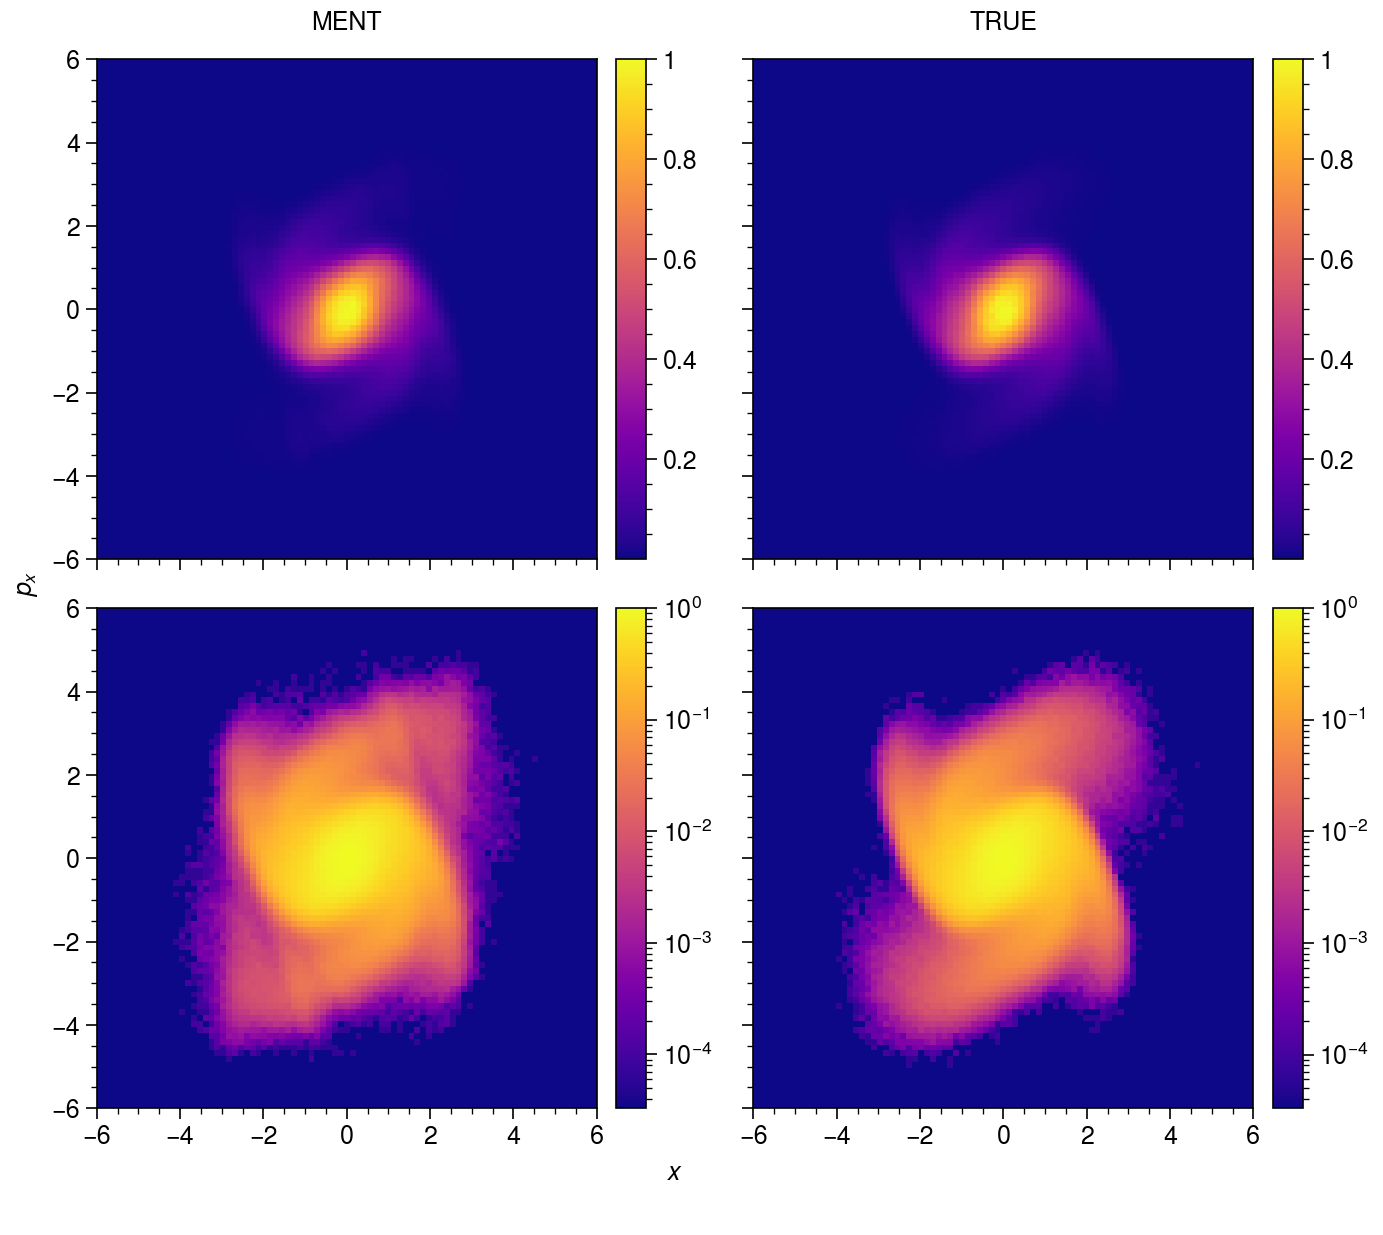

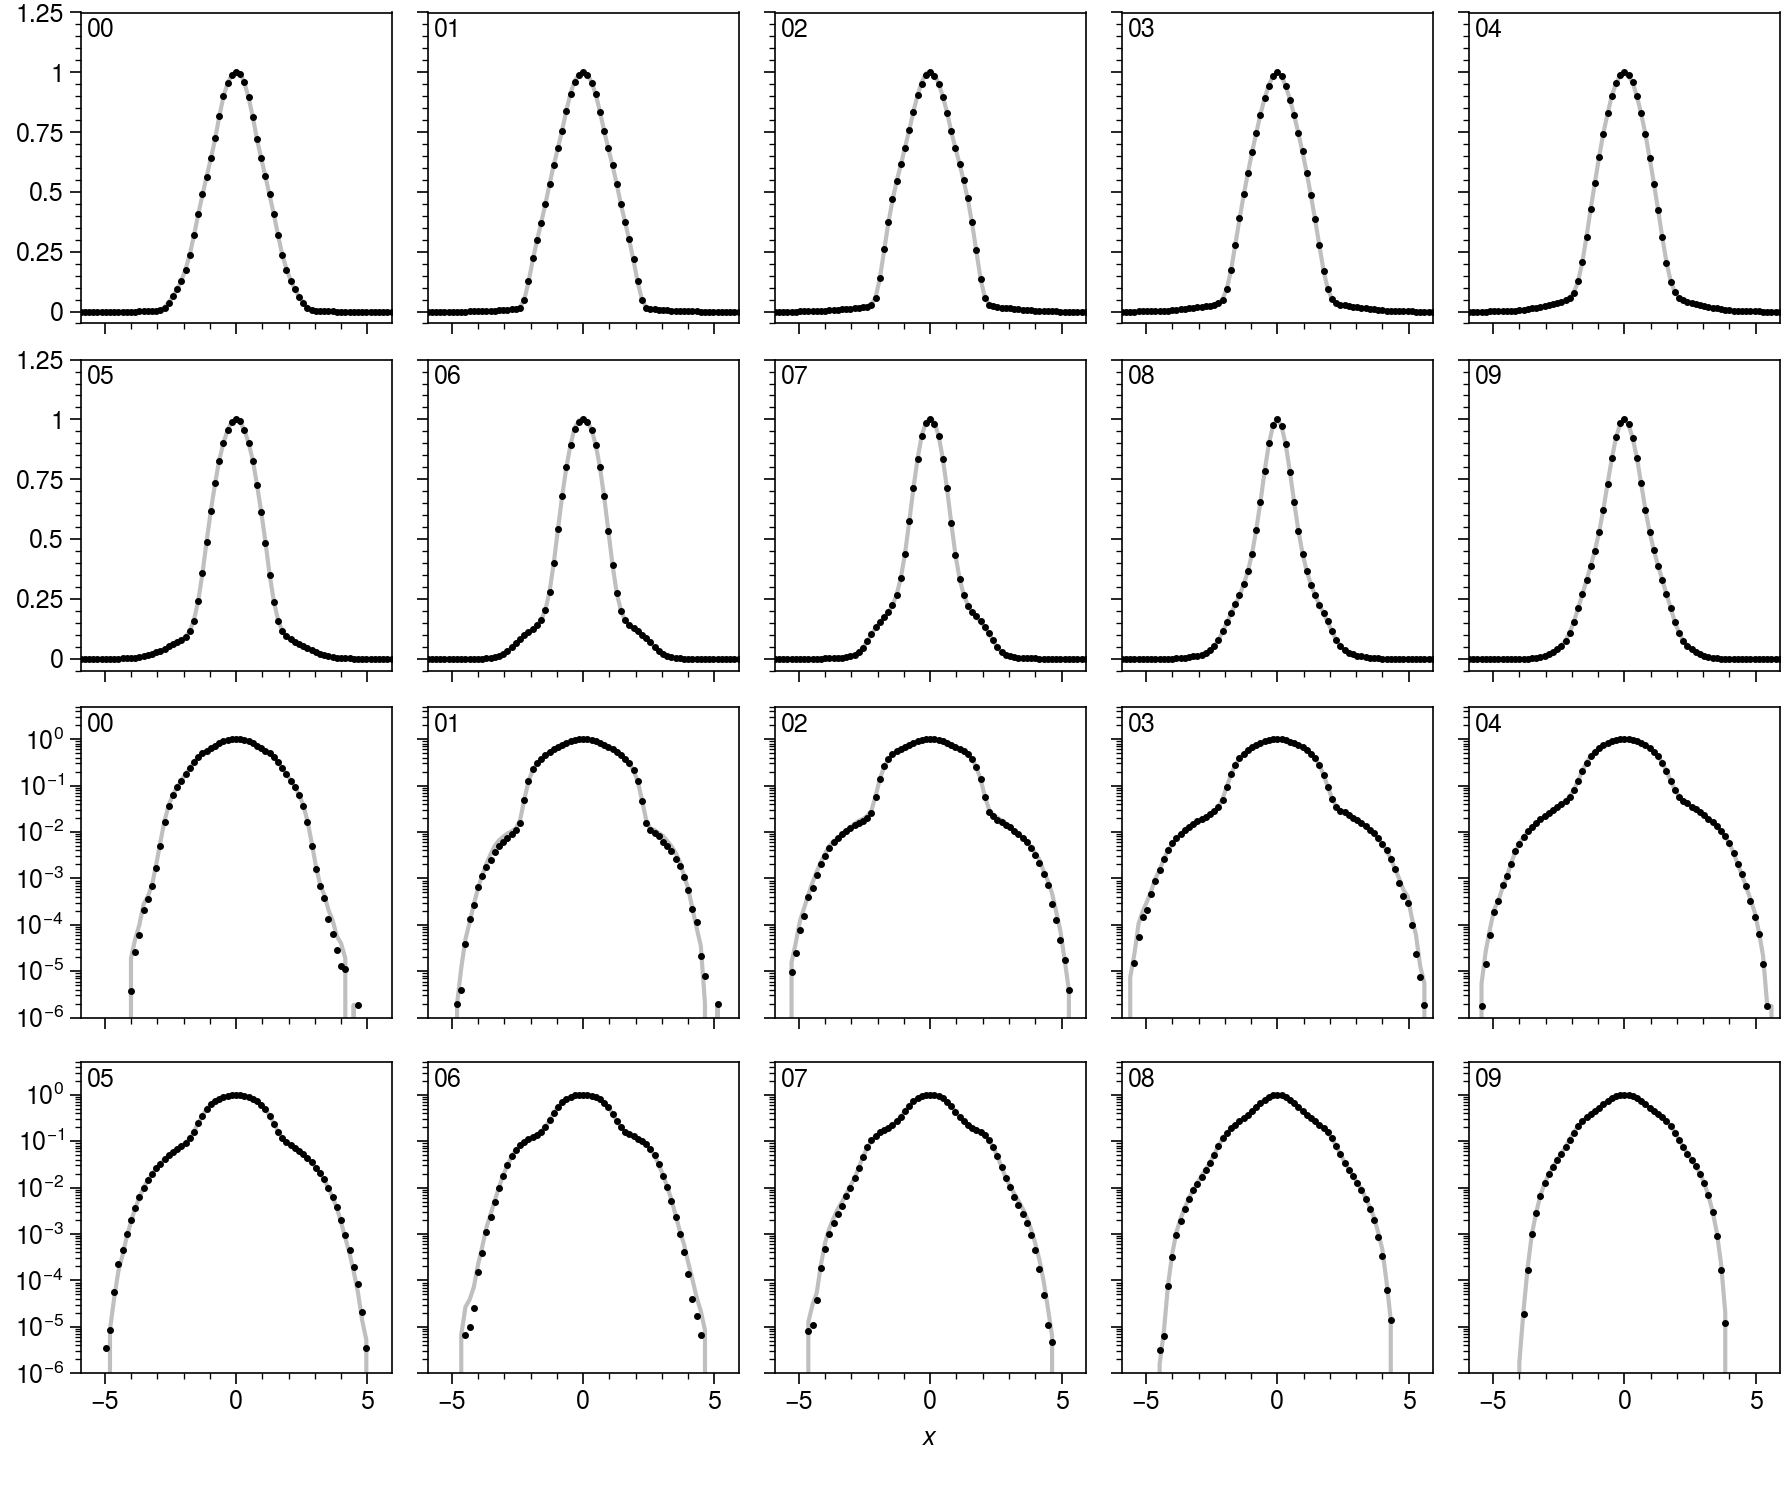

In [10]:
for epoch in range(7):
    print("epoch = {}".format(epoch))

    # Sample particles from the distribution.
    x_pred = model.sample(x_true.shape[0])

    # Plot the phase space density.
    plot_model_dist(x_pred)
    plt.show()

    # Plot the simulated vs. measured projections.
    plot_model_proj(x_pred)
    plt.show()
    
    # Update the model parameters (Lagrange multipliers).
    model.gauss_seidel_step(learning_rate=0.75)

These are great results! We recover the projections with six decades of dyanmic range. That's one million times smaller than the peak, as in 0.000001. As far as I'm aware, no one has reported reconstructions with such high dynamic range. I'm hoping to test this algorithm on real data from the SNS linac in the near future.